In [1]:
import h5py
import importlib
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import tensorflow as tf
import yaml
import logomaker
import tfomics
from tfomics import impress, explain, moana

from hominid_pipeline import utils, model_zoo, hominid, layers

2023-06-15 10:06:46.369733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 10:06:47.235396: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-15 10:06:47.235478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-15 10:06:47.235488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
working_dir = "/home/chandana/projects/hominid_pipeline/results"
hits = [
    "experiments/sweeps/tune_hominid_8f34a_00085_85_conv1_activation=exponential,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=se_2023-05-18_00-04-12",
    "experiments/sweeps/tune_hominid_8f34a_00185_185_conv1_activation=relu,conv1_attention_pool_size=23,conv1_batchnorm=True,conv1_channel_weight=softconv_2023-05-18_06-11-38",
    "experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential", # this one!
    "experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential",
    "experiments/model_variations/tune_hominid_8f34a_00058_58_conv1_activation=relu,conv1_attention_pool_size=30,conv1_batchnorm=False,conv1_channel_weight=softconv_2023-05-17_22-09-59/exponential/variations/variation_1",
    "experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/variations/128-filters/"
    
]

In [4]:
!echo $CUDA_VISIBLE_DEVICES

4


In [5]:
index = -1
save_path = f"{working_dir}/{hits[index]}"
config_file = f"{working_dir}/{hits[index]}/config.yaml"
config = hominid.load_config(config_file)

tuner = hominid.HominidTuner(
    config, 
    epochs=100, 
    tuning_mode=False, 
    save_path=save_path, 
    subsample=False
)

tuner.save_path

'/home/chandana/projects/hominid_pipeline/results/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/variations/128-filters/'

In [4]:
print(f"python run_gia.py --config_file={config_file}")

python run_gia.py --config_file=/home/chandana/projects/hominid_pipeline/results/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/variations/128-filters//config.yaml


In [6]:
print(f"Loading model and dataset!")

x_test, y_test = tuner.data_processor.load_data("test")

# Build the model
model = tuner.model_builder.build_model()

model.compile(
    tf.keras.optimizers.Adam(lr=0.001),
    loss='mse',
    metrics=[utils.Spearman, utils.pearson_r]
    )
print(model.summary())
model.load_weights(f'{tuner.save_path}/weights')

print(f"Interpreting filters!")

Loading model and dataset!
Building model...


2023-06-15 10:07:23.871452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 10:07:24.379977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14239 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:81:00.0, compute capability: 8.6


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 128)    234368      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 128)     512         ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 128)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 2,915,778
Trainable params: 2,913,474
Non-trainable params: 2,304
__________________________________________________________________________________________________
None
Interpreting filters!


Evaluating first layer!
Loading model and dataset!
Building model...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 128)    234368      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 128)     512         ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 128)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 2,915,778
Trainable params: 2,913,474
Non-trainable params: 2,304
__________________________________________________________________________________________________
None
Interpreting filters!
Making intermediate predictions...


  0%|                                                                                             | 0/643 [00:00<?, ?it/s]

2/2 [==============================] - 1s 4ms/step


2023-06-15 10:07:35.168618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
  0%|▏                                                                                    | 1/643 [00:00<08:12,  1.30it/s]

2/2 [==============================] - 0s 3ms/step


  0%|▍                                                                                    | 3/643 [00:00<02:34,  4.14it/s]

2/2 [==============================] - 0s 2ms/step


  1%|▋                                                                                    | 5/643 [00:00<01:33,  6.84it/s]

2/2 [==============================] - 0s 3ms/step


  1%|▉                                                                                    | 7/643 [00:01<01:09,  9.18it/s]

2/2 [==============================] - 0s 2ms/step


  1%|█▏                                                                                   | 9/643 [00:01<00:56, 11.30it/s]

2/2 [==============================] - 0s 3ms/step


  2%|█▍                                                                                  | 11/643 [00:01<00:48, 13.03it/s]

2/2 [==============================] - 0s 2ms/step


  2%|█▋                                                                                  | 13/643 [00:01<00:44, 14.28it/s]

2/2 [==============================] - 0s 2ms/step


  2%|█▉                                                                                  | 15/643 [00:01<00:41, 15.31it/s]

2/2 [==============================] - 0s 2ms/step


  3%|██▏                                                                                 | 17/643 [00:01<00:38, 16.10it/s]

2/2 [==============================] - 0s 3ms/step


  3%|██▍                                                                                 | 19/643 [00:01<00:38, 16.38it/s]

2/2 [==============================] - 0s 2ms/step


  3%|██▋                                                                                 | 21/643 [00:01<00:37, 16.55it/s]

2/2 [==============================] - 0s 3ms/step


  4%|███                                                                                 | 23/643 [00:02<00:37, 16.60it/s]

2/2 [==============================] - 0s 2ms/step


  4%|███▎                                                                                | 25/643 [00:02<00:37, 16.62it/s]

2/2 [==============================] - 0s 2ms/step


  4%|███▌                                                                                | 27/643 [00:02<00:36, 16.86it/s]

2/2 [==============================] - 0s 2ms/step


  5%|███▊                                                                                | 29/643 [00:02<00:36, 17.01it/s]

2/2 [==============================] - 0s 3ms/step


  5%|████                                                                                | 31/643 [00:02<00:35, 17.24it/s]

2/2 [==============================] - 0s 2ms/step


  5%|████▎                                                                               | 33/643 [00:02<00:35, 17.30it/s]

2/2 [==============================] - 0s 3ms/step


  5%|████▌                                                                               | 35/643 [00:02<00:35, 17.03it/s]

2/2 [==============================] - 0s 2ms/step


  6%|████▊                                                                               | 37/643 [00:02<00:35, 17.06it/s]

2/2 [==============================] - 0s 2ms/step


  6%|█████                                                                               | 39/643 [00:02<00:34, 17.28it/s]

2/2 [==============================] - 0s 2ms/step


  6%|█████▎                                                                              | 41/643 [00:03<00:34, 17.31it/s]

2/2 [==============================] - 0s 2ms/step


  7%|█████▌                                                                              | 43/643 [00:03<00:34, 17.35it/s]

2/2 [==============================] - 0s 2ms/step


  7%|█████▉                                                                              | 45/643 [00:03<00:33, 17.64it/s]

2/2 [==============================] - 0s 2ms/step


  7%|██████▏                                                                             | 47/643 [00:03<00:34, 17.34it/s]

2/2 [==============================] - 0s 2ms/step


  8%|██████▍                                                                             | 49/643 [00:03<00:33, 17.49it/s]

2/2 [==============================] - 0s 2ms/step


  8%|██████▋                                                                             | 51/643 [00:03<00:33, 17.66it/s]

2/2 [==============================] - 0s 2ms/step


  8%|██████▉                                                                             | 53/643 [00:03<00:33, 17.53it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████▏                                                                            | 55/643 [00:03<00:33, 17.77it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████▍                                                                            | 57/643 [00:03<00:33, 17.59it/s]

2/2 [==============================] - 0s 3ms/step


  9%|███████▋                                                                            | 59/643 [00:04<00:33, 17.22it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████▉                                                                            | 61/643 [00:04<00:33, 17.20it/s]

2/2 [==============================] - 0s 2ms/step


 10%|████████▏                                                                           | 63/643 [00:04<00:34, 16.99it/s]

2/2 [==============================] - 0s 3ms/step


 10%|████████▍                                                                           | 65/643 [00:04<00:33, 17.13it/s]

2/2 [==============================] - 0s 2ms/step


 10%|████████▊                                                                           | 67/643 [00:04<00:32, 17.49it/s]

2/2 [==============================] - 0s 2ms/step


 11%|█████████                                                                           | 69/643 [00:04<00:32, 17.72it/s]

2/2 [==============================] - 0s 3ms/step


 11%|█████████▎                                                                          | 71/643 [00:04<00:32, 17.78it/s]

2/2 [==============================] - 0s 2ms/step


 11%|█████████▌                                                                          | 73/643 [00:04<00:32, 17.79it/s]

2/2 [==============================] - 0s 2ms/step


 12%|█████████▊                                                                          | 75/643 [00:04<00:31, 17.94it/s]

2/2 [==============================] - 0s 2ms/step


 12%|██████████                                                                          | 77/643 [00:05<00:31, 18.11it/s]

2/2 [==============================] - 0s 2ms/step


 12%|██████████▎                                                                         | 79/643 [00:05<00:30, 18.27it/s]

2/2 [==============================] - 0s 2ms/step


 13%|██████████▌                                                                         | 81/643 [00:05<00:31, 18.00it/s]

2/2 [==============================] - 0s 2ms/step


 13%|██████████▊                                                                         | 83/643 [00:05<00:31, 17.78it/s]

2/2 [==============================] - 0s 3ms/step


 13%|███████████                                                                         | 85/643 [00:05<00:31, 17.76it/s]

2/2 [==============================] - 0s 2ms/step


 14%|███████████▎                                                                        | 87/643 [00:05<00:31, 17.88it/s]

2/2 [==============================] - 0s 2ms/step


 14%|███████████▋                                                                        | 89/643 [00:05<00:31, 17.81it/s]

2/2 [==============================] - 0s 2ms/step


 14%|███████████▉                                                                        | 91/643 [00:05<00:31, 17.31it/s]

2/2 [==============================] - 0s 2ms/step


 14%|████████████▏                                                                       | 93/643 [00:06<00:32, 16.81it/s]

2/2 [==============================] - 0s 2ms/step


 15%|████████████▍                                                                       | 95/643 [00:06<00:32, 16.88it/s]

2/2 [==============================] - 0s 2ms/step


 15%|████████████▋                                                                       | 97/643 [00:06<00:32, 17.01it/s]

2/2 [==============================] - 0s 2ms/step


 15%|████████████▉                                                                       | 99/643 [00:06<00:31, 17.37it/s]

2/2 [==============================] - 0s 2ms/step


 16%|█████████████                                                                      | 101/643 [00:06<00:30, 17.50it/s]

2/2 [==============================] - 0s 2ms/step


 16%|█████████████▎                                                                     | 103/643 [00:06<00:31, 17.13it/s]

2/2 [==============================] - 0s 3ms/step


 16%|█████████████▌                                                                     | 105/643 [00:06<00:31, 17.22it/s]

2/2 [==============================] - 0s 2ms/step


 17%|█████████████▊                                                                     | 107/643 [00:06<00:30, 17.42it/s]

2/2 [==============================] - 0s 2ms/step


 17%|██████████████                                                                     | 109/643 [00:06<00:30, 17.76it/s]

2/2 [==============================] - 0s 2ms/step


 17%|██████████████▎                                                                    | 111/643 [00:07<00:30, 17.36it/s]

2/2 [==============================] - 0s 3ms/step


 18%|██████████████▌                                                                    | 113/643 [00:07<00:30, 17.52it/s]

2/2 [==============================] - 0s 2ms/step


 18%|██████████████▊                                                                    | 115/643 [00:07<00:30, 17.39it/s]

2/2 [==============================] - 0s 2ms/step


 18%|███████████████                                                                    | 117/643 [00:07<00:30, 17.45it/s]

2/2 [==============================] - 0s 3ms/step


 19%|███████████████▎                                                                   | 119/643 [00:07<00:29, 17.57it/s]

2/2 [==============================] - 0s 2ms/step


 19%|███████████████▌                                                                   | 121/643 [00:07<00:29, 17.49it/s]

2/2 [==============================] - 0s 3ms/step


 19%|███████████████▉                                                                   | 123/643 [00:07<00:29, 17.38it/s]

2/2 [==============================] - 0s 3ms/step


 19%|████████████████▏                                                                  | 125/643 [00:07<00:30, 17.23it/s]

2/2 [==============================] - 0s 3ms/step


 20%|████████████████▍                                                                  | 127/643 [00:07<00:29, 17.52it/s]

2/2 [==============================] - 0s 2ms/step


 20%|████████████████▋                                                                  | 129/643 [00:08<00:29, 17.66it/s]

2/2 [==============================] - 0s 2ms/step


 20%|████████████████▉                                                                  | 131/643 [00:08<00:29, 17.48it/s]

2/2 [==============================] - 0s 2ms/step


 21%|█████████████████▏                                                                 | 133/643 [00:08<00:29, 17.58it/s]

2/2 [==============================] - 0s 2ms/step


 21%|█████████████████▍                                                                 | 135/643 [00:08<00:28, 17.76it/s]

2/2 [==============================] - 0s 3ms/step


 21%|█████████████████▋                                                                 | 137/643 [00:08<00:28, 17.47it/s]

2/2 [==============================] - 0s 2ms/step


 22%|█████████████████▉                                                                 | 139/643 [00:08<00:28, 17.68it/s]

2/2 [==============================] - 0s 2ms/step


 22%|██████████████████▏                                                                | 141/643 [00:08<00:29, 17.09it/s]

2/2 [==============================] - 0s 3ms/step


 22%|██████████████████▍                                                                | 143/643 [00:08<00:29, 17.02it/s]

2/2 [==============================] - 0s 2ms/step


 23%|██████████████████▋                                                                | 145/643 [00:09<00:29, 16.94it/s]

2/2 [==============================] - 0s 2ms/step


 23%|██████████████████▉                                                                | 147/643 [00:09<00:29, 16.88it/s]

2/2 [==============================] - 0s 3ms/step


 23%|███████████████████▏                                                               | 149/643 [00:09<00:29, 16.48it/s]

2/2 [==============================] - 0s 2ms/step


 23%|███████████████████▍                                                               | 151/643 [00:09<00:29, 16.50it/s]

2/2 [==============================] - 0s 3ms/step


 24%|███████████████████▋                                                               | 153/643 [00:09<00:29, 16.73it/s]

2/2 [==============================] - 0s 3ms/step


 24%|████████████████████                                                               | 155/643 [00:09<00:28, 17.01it/s]

2/2 [==============================] - 0s 2ms/step


 24%|████████████████████▎                                                              | 157/643 [00:09<00:28, 17.28it/s]

2/2 [==============================] - 0s 2ms/step


 25%|████████████████████▌                                                              | 159/643 [00:09<00:27, 17.43it/s]

2/2 [==============================] - 0s 2ms/step


 25%|████████████████████▊                                                              | 161/643 [00:09<00:27, 17.46it/s]

2/2 [==============================] - 0s 2ms/step


 25%|█████████████████████                                                              | 163/643 [00:10<00:27, 17.66it/s]

2/2 [==============================] - 0s 3ms/step


 26%|█████████████████████▎                                                             | 165/643 [00:10<00:27, 17.67it/s]

2/2 [==============================] - 0s 2ms/step


 26%|█████████████████████▌                                                             | 167/643 [00:10<00:27, 17.62it/s]

2/2 [==============================] - 0s 2ms/step


 26%|█████████████████████▊                                                             | 169/643 [00:10<00:26, 17.62it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████                                                             | 171/643 [00:10<00:26, 17.61it/s]

2/2 [==============================] - 0s 3ms/step


 27%|██████████████████████▎                                                            | 173/643 [00:10<00:26, 17.45it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████▌                                                            | 175/643 [00:10<00:26, 17.80it/s]

2/2 [==============================] - 0s 3ms/step


 28%|██████████████████████▊                                                            | 177/643 [00:10<00:26, 17.79it/s]

2/2 [==============================] - 0s 3ms/step


 28%|███████████████████████                                                            | 179/643 [00:10<00:27, 16.86it/s]

2/2 [==============================] - 0s 2ms/step


 28%|███████████████████████▎                                                           | 181/643 [00:11<00:27, 16.76it/s]

2/2 [==============================] - 0s 2ms/step


 28%|███████████████████████▌                                                           | 183/643 [00:11<00:26, 17.05it/s]

2/2 [==============================] - 0s 2ms/step


 29%|███████████████████████▉                                                           | 185/643 [00:11<00:26, 17.29it/s]

2/2 [==============================] - 0s 2ms/step


 29%|████████████████████████▏                                                          | 187/643 [00:11<00:25, 17.58it/s]

2/2 [==============================] - 0s 2ms/step


 29%|████████████████████████▍                                                          | 189/643 [00:11<00:30, 14.70it/s]

2/2 [==============================] - 0s 2ms/step


 30%|████████████████████████▋                                                          | 191/643 [00:11<00:29, 15.25it/s]

2/2 [==============================] - 0s 3ms/step


 30%|████████████████████████▉                                                          | 193/643 [00:11<00:28, 15.91it/s]

2/2 [==============================] - 0s 2ms/step


 30%|█████████████████████████▏                                                         | 195/643 [00:11<00:27, 16.50it/s]

2/2 [==============================] - 0s 3ms/step


 31%|█████████████████████████▍                                                         | 197/643 [00:12<00:26, 16.77it/s]

2/2 [==============================] - 0s 3ms/step


 31%|█████████████████████████▋                                                         | 199/643 [00:12<00:26, 16.78it/s]

2/2 [==============================] - 0s 2ms/step


 31%|█████████████████████████▉                                                         | 201/643 [00:12<00:26, 16.57it/s]

2/2 [==============================] - 0s 3ms/step


 32%|██████████████████████████▏                                                        | 203/643 [00:12<00:26, 16.87it/s]

2/2 [==============================] - 0s 3ms/step


 32%|██████████████████████████▍                                                        | 205/643 [00:12<00:25, 17.17it/s]

2/2 [==============================] - 0s 2ms/step


 32%|██████████████████████████▋                                                        | 207/643 [00:12<00:25, 16.94it/s]

2/2 [==============================] - 0s 2ms/step


 33%|██████████████████████████▉                                                        | 209/643 [00:12<00:25, 16.93it/s]

2/2 [==============================] - 0s 2ms/step


 33%|███████████████████████████▏                                                       | 211/643 [00:12<00:25, 17.03it/s]

2/2 [==============================] - 0s 3ms/step


 33%|███████████████████████████▍                                                       | 213/643 [00:13<00:25, 16.56it/s]

2/2 [==============================] - 0s 2ms/step


 33%|███████████████████████████▊                                                       | 215/643 [00:13<00:25, 16.95it/s]

2/2 [==============================] - 0s 3ms/step


 34%|████████████████████████████                                                       | 217/643 [00:13<00:25, 16.86it/s]

2/2 [==============================] - 0s 3ms/step


 34%|████████████████████████████▎                                                      | 219/643 [00:13<00:24, 16.97it/s]

2/2 [==============================] - 0s 2ms/step


 34%|████████████████████████████▌                                                      | 221/643 [00:13<00:24, 16.93it/s]

2/2 [==============================] - 0s 2ms/step


 35%|████████████████████████████▊                                                      | 223/643 [00:13<00:24, 17.16it/s]

2/2 [==============================] - 0s 2ms/step


 35%|█████████████████████████████                                                      | 225/643 [00:13<00:24, 16.95it/s]

2/2 [==============================] - 0s 3ms/step


 35%|█████████████████████████████▎                                                     | 227/643 [00:13<00:24, 17.11it/s]

2/2 [==============================] - 0s 3ms/step


 36%|█████████████████████████████▌                                                     | 229/643 [00:13<00:24, 16.97it/s]

2/2 [==============================] - 0s 2ms/step


 36%|█████████████████████████████▊                                                     | 231/643 [00:14<00:24, 17.08it/s]

2/2 [==============================] - 0s 2ms/step


 36%|██████████████████████████████                                                     | 233/643 [00:14<00:23, 17.26it/s]

2/2 [==============================] - 0s 2ms/step


 37%|██████████████████████████████▎                                                    | 235/643 [00:14<00:23, 17.46it/s]

2/2 [==============================] - 0s 2ms/step


 37%|██████████████████████████████▌                                                    | 237/643 [00:14<00:24, 16.55it/s]

2/2 [==============================] - 0s 4ms/step


 37%|██████████████████████████████▊                                                    | 239/643 [00:14<00:24, 16.82it/s]

2/2 [==============================] - 0s 3ms/step


 37%|███████████████████████████████                                                    | 241/643 [00:14<00:23, 16.94it/s]

2/2 [==============================] - 0s 3ms/step


 38%|███████████████████████████████▎                                                   | 243/643 [00:14<00:23, 16.97it/s]

2/2 [==============================] - 0s 2ms/step


 38%|███████████████████████████████▋                                                   | 245/643 [00:14<00:23, 16.92it/s]

2/2 [==============================] - 0s 2ms/step


 38%|███████████████████████████████▉                                                   | 247/643 [00:15<00:22, 17.24it/s]

2/2 [==============================] - 0s 3ms/step


 39%|████████████████████████████████▏                                                  | 249/643 [00:15<00:22, 17.24it/s]

2/2 [==============================] - 0s 2ms/step


 39%|████████████████████████████████▍                                                  | 251/643 [00:15<00:25, 15.45it/s]

2/2 [==============================] - 0s 2ms/step


 39%|████████████████████████████████▋                                                  | 253/643 [00:15<00:24, 16.12it/s]

2/2 [==============================] - 0s 2ms/step


 40%|████████████████████████████████▉                                                  | 255/643 [00:15<00:23, 16.36it/s]

2/2 [==============================] - 0s 3ms/step


 40%|█████████████████████████████████▏                                                 | 257/643 [00:15<00:23, 16.72it/s]

2/2 [==============================] - 0s 3ms/step


 40%|█████████████████████████████████▍                                                 | 259/643 [00:15<00:22, 16.91it/s]

2/2 [==============================] - 0s 3ms/step


 41%|█████████████████████████████████▋                                                 | 261/643 [00:15<00:23, 16.58it/s]

2/2 [==============================] - 0s 2ms/step


 41%|█████████████████████████████████▉                                                 | 263/643 [00:16<00:25, 14.65it/s]

2/2 [==============================] - 0s 2ms/step


 41%|██████████████████████████████████▏                                                | 265/643 [00:16<00:24, 15.43it/s]

2/2 [==============================] - 0s 2ms/step


 42%|██████████████████████████████████▍                                                | 267/643 [00:16<00:23, 16.20it/s]

2/2 [==============================] - 0s 2ms/step


 42%|██████████████████████████████████▋                                                | 269/643 [00:16<00:22, 16.74it/s]

2/2 [==============================] - 0s 2ms/step


 42%|██████████████████████████████████▉                                                | 271/643 [00:16<00:22, 16.72it/s]

2/2 [==============================] - 0s 3ms/step


 42%|███████████████████████████████████▏                                               | 273/643 [00:16<00:24, 15.03it/s]

2/2 [==============================] - 0s 3ms/step


 43%|███████████████████████████████████▍                                               | 275/643 [00:16<00:23, 15.33it/s]

2/2 [==============================] - 0s 3ms/step


 43%|███████████████████████████████████▊                                               | 277/643 [00:16<00:23, 15.53it/s]

2/2 [==============================] - 0s 3ms/step


 43%|████████████████████████████████████                                               | 279/643 [00:17<00:22, 15.95it/s]

2/2 [==============================] - 1s 3ms/step


 44%|████████████████████████████████████▎                                              | 281/643 [00:18<01:10,  5.10it/s]

2/2 [==============================] - 0s 2ms/step


 44%|████████████████████████████████████▌                                              | 283/643 [00:18<00:55,  6.45it/s]

2/2 [==============================] - 0s 3ms/step


 44%|████████████████████████████████████▊                                              | 285/643 [00:18<00:45,  7.83it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████                                              | 287/643 [00:18<00:37,  9.46it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████▎                                             | 289/643 [00:18<00:32, 10.95it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████▌                                             | 291/643 [00:18<00:29, 12.14it/s]

2/2 [==============================] - 0s 2ms/step


 46%|█████████████████████████████████████▊                                             | 293/643 [00:18<00:26, 13.42it/s]

2/2 [==============================] - 0s 2ms/step


 46%|██████████████████████████████████████                                             | 295/643 [00:18<00:23, 14.56it/s]

2/2 [==============================] - 0s 2ms/step


 46%|██████████████████████████████████████▎                                            | 297/643 [00:18<00:22, 15.18it/s]

2/2 [==============================] - 0s 2ms/step


 47%|██████████████████████████████████████▌                                            | 299/643 [00:19<00:21, 15.80it/s]

2/2 [==============================] - 0s 3ms/step


 47%|██████████████████████████████████████▊                                            | 301/643 [00:19<00:21, 15.96it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████                                            | 303/643 [00:19<00:20, 16.42it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████▎                                           | 305/643 [00:19<00:19, 16.94it/s]

2/2 [==============================] - 0s 2ms/step


 48%|███████████████████████████████████████▋                                           | 307/643 [00:19<00:19, 17.29it/s]

2/2 [==============================] - 0s 2ms/step


 48%|███████████████████████████████████████▉                                           | 309/643 [00:19<00:19, 17.52it/s]

2/2 [==============================] - 0s 2ms/step


 48%|████████████████████████████████████████▏                                          | 311/643 [00:19<00:19, 17.41it/s]

2/2 [==============================] - 0s 2ms/step


 49%|████████████████████████████████████████▍                                          | 313/643 [00:19<00:19, 17.34it/s]

2/2 [==============================] - 0s 3ms/step


 49%|████████████████████████████████████████▋                                          | 315/643 [00:20<00:18, 17.45it/s]

2/2 [==============================] - 0s 2ms/step


 49%|████████████████████████████████████████▉                                          | 317/643 [00:20<00:18, 17.38it/s]

2/2 [==============================] - 0s 3ms/step


 50%|█████████████████████████████████████████▏                                         | 319/643 [00:20<00:18, 17.52it/s]

2/2 [==============================] - 0s 3ms/step


 50%|█████████████████████████████████████████▍                                         | 321/643 [00:20<00:19, 16.82it/s]

2/2 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████▋                                         | 323/643 [00:20<00:18, 17.01it/s]

2/2 [==============================] - 0s 3ms/step


 51%|█████████████████████████████████████████▉                                         | 325/643 [00:20<00:18, 17.07it/s]

2/2 [==============================] - 0s 2ms/step


 51%|██████████████████████████████████████████▏                                        | 327/643 [00:20<00:18, 17.32it/s]

2/2 [==============================] - 0s 2ms/step


 51%|██████████████████████████████████████████▍                                        | 329/643 [00:20<00:17, 17.45it/s]

2/2 [==============================] - 0s 3ms/step


 51%|██████████████████████████████████████████▋                                        | 331/643 [00:20<00:17, 17.38it/s]

2/2 [==============================] - 0s 2ms/step


 52%|██████████████████████████████████████████▉                                        | 333/643 [00:21<00:18, 17.07it/s]

2/2 [==============================] - 0s 3ms/step


 52%|███████████████████████████████████████████▏                                       | 335/643 [00:21<00:17, 17.31it/s]

2/2 [==============================] - 0s 2ms/step


 52%|███████████████████████████████████████████▌                                       | 337/643 [00:21<00:17, 17.11it/s]

2/2 [==============================] - 0s 3ms/step


 53%|███████████████████████████████████████████▊                                       | 339/643 [00:21<00:20, 15.07it/s]

2/2 [==============================] - 0s 3ms/step


 53%|████████████████████████████████████████████                                       | 341/643 [00:21<00:23, 13.11it/s]

2/2 [==============================] - 0s 2ms/step


 53%|████████████████████████████████████████████▎                                      | 343/643 [00:21<00:21, 14.23it/s]

2/2 [==============================] - 0s 3ms/step


 54%|████████████████████████████████████████████▌                                      | 345/643 [00:21<00:19, 14.98it/s]

2/2 [==============================] - 0s 3ms/step


 54%|████████████████████████████████████████████▊                                      | 347/643 [00:22<00:18, 15.61it/s]

2/2 [==============================] - 0s 3ms/step


 54%|█████████████████████████████████████████████                                      | 349/643 [00:22<00:18, 16.11it/s]

2/2 [==============================] - 0s 3ms/step


 55%|█████████████████████████████████████████████▎                                     | 351/643 [00:22<00:17, 16.35it/s]

2/2 [==============================] - 0s 3ms/step


 55%|█████████████████████████████████████████████▌                                     | 353/643 [00:22<00:18, 15.69it/s]

2/2 [==============================] - 0s 2ms/step


 55%|█████████████████████████████████████████████▊                                     | 355/643 [00:22<00:17, 16.30it/s]

2/2 [==============================] - 0s 3ms/step


 56%|██████████████████████████████████████████████                                     | 357/643 [00:22<00:17, 16.73it/s]

2/2 [==============================] - 0s 2ms/step


 56%|██████████████████████████████████████████████▎                                    | 359/643 [00:22<00:16, 17.03it/s]

2/2 [==============================] - 0s 2ms/step


 56%|██████████████████████████████████████████████▌                                    | 361/643 [00:22<00:16, 16.93it/s]

2/2 [==============================] - 0s 3ms/step


 56%|██████████████████████████████████████████████▊                                    | 363/643 [00:22<00:17, 15.66it/s]

2/2 [==============================] - 0s 3ms/step


 57%|███████████████████████████████████████████████                                    | 365/643 [00:23<00:17, 15.94it/s]

2/2 [==============================] - 0s 2ms/step


 57%|███████████████████████████████████████████████▎                                   | 367/643 [00:23<00:16, 16.53it/s]

2/2 [==============================] - 0s 2ms/step


 57%|███████████████████████████████████████████████▋                                   | 369/643 [00:23<00:16, 16.68it/s]

2/2 [==============================] - 0s 2ms/step


 58%|███████████████████████████████████████████████▉                                   | 371/643 [00:23<00:16, 16.31it/s]

2/2 [==============================] - 0s 3ms/step


 58%|████████████████████████████████████████████████▏                                  | 373/643 [00:23<00:26, 10.06it/s]

2/2 [==============================] - 0s 2ms/step


 58%|████████████████████████████████████████████████▍                                  | 375/643 [00:23<00:23, 11.25it/s]

2/2 [==============================] - 0s 3ms/step


 59%|████████████████████████████████████████████████▋                                  | 377/643 [00:24<00:21, 12.25it/s]

2/2 [==============================] - 0s 3ms/step


 59%|████████████████████████████████████████████████▉                                  | 379/643 [00:24<00:19, 13.22it/s]

2/2 [==============================] - 0s 3ms/step


 59%|█████████████████████████████████████████████████▏                                 | 381/643 [00:24<00:18, 13.81it/s]

2/2 [==============================] - 0s 2ms/step


 60%|█████████████████████████████████████████████████▍                                 | 383/643 [00:24<00:18, 14.32it/s]

2/2 [==============================] - 0s 3ms/step


 60%|█████████████████████████████████████████████████▋                                 | 385/643 [00:24<00:17, 14.60it/s]

2/2 [==============================] - 0s 3ms/step


 60%|█████████████████████████████████████████████████▉                                 | 387/643 [00:24<00:16, 15.07it/s]

2/2 [==============================] - 0s 2ms/step


 60%|██████████████████████████████████████████████████▏                                | 389/643 [00:24<00:16, 15.42it/s]

2/2 [==============================] - 0s 2ms/step


 61%|██████████████████████████████████████████████████▍                                | 391/643 [00:24<00:16, 15.50it/s]

2/2 [==============================] - 0s 3ms/step


 61%|██████████████████████████████████████████████████▋                                | 393/643 [00:25<00:15, 15.96it/s]

2/2 [==============================] - 0s 3ms/step


 61%|██████████████████████████████████████████████████▉                                | 395/643 [00:25<00:15, 15.84it/s]

2/2 [==============================] - 0s 3ms/step


 62%|███████████████████████████████████████████████████▏                               | 397/643 [00:25<00:16, 14.62it/s]

2/2 [==============================] - 0s 3ms/step


 62%|███████████████████████████████████████████████████▌                               | 399/643 [00:25<00:15, 15.30it/s]

2/2 [==============================] - 0s 2ms/step


 62%|███████████████████████████████████████████████████▊                               | 401/643 [00:25<00:15, 15.41it/s]

2/2 [==============================] - 0s 3ms/step


 63%|████████████████████████████████████████████████████                               | 403/643 [00:25<00:15, 15.63it/s]

2/2 [==============================] - 0s 2ms/step


 63%|████████████████████████████████████████████████████▎                              | 405/643 [00:25<00:14, 16.05it/s]

2/2 [==============================] - 0s 3ms/step


 63%|████████████████████████████████████████████████████▌                              | 407/643 [00:26<00:14, 16.43it/s]

2/2 [==============================] - 0s 3ms/step


 64%|████████████████████████████████████████████████████▊                              | 409/643 [00:26<00:17, 13.41it/s]

2/2 [==============================] - 0s 3ms/step


 64%|█████████████████████████████████████████████████████                              | 411/643 [00:26<00:16, 14.07it/s]

2/2 [==============================] - 0s 3ms/step


 64%|█████████████████████████████████████████████████████▎                             | 413/643 [00:26<00:15, 14.79it/s]

2/2 [==============================] - 0s 3ms/step


 65%|█████████████████████████████████████████████████████▌                             | 415/643 [00:26<00:14, 15.51it/s]

2/2 [==============================] - 0s 2ms/step


 65%|█████████████████████████████████████████████████████▊                             | 417/643 [00:26<00:14, 15.13it/s]

2/2 [==============================] - 0s 2ms/step


 65%|██████████████████████████████████████████████████████                             | 419/643 [00:26<00:14, 15.46it/s]

2/2 [==============================] - 0s 2ms/step


 65%|██████████████████████████████████████████████████████▎                            | 421/643 [00:26<00:13, 16.06it/s]

2/2 [==============================] - 0s 2ms/step


 66%|██████████████████████████████████████████████████████▌                            | 423/643 [00:27<00:13, 16.46it/s]

2/2 [==============================] - 0s 2ms/step


 66%|██████████████████████████████████████████████████████▊                            | 425/643 [00:27<00:12, 16.84it/s]

2/2 [==============================] - 0s 2ms/step


 66%|███████████████████████████████████████████████████████                            | 427/643 [00:27<00:12, 16.77it/s]

2/2 [==============================] - 0s 2ms/step


 67%|███████████████████████████████████████████████████████▍                           | 429/643 [00:27<00:12, 16.75it/s]

2/2 [==============================] - 0s 2ms/step


 67%|███████████████████████████████████████████████████████▋                           | 431/643 [00:27<00:12, 16.65it/s]

2/2 [==============================] - 0s 3ms/step


 67%|███████████████████████████████████████████████████████▉                           | 433/643 [00:27<00:14, 14.87it/s]

2/2 [==============================] - 0s 2ms/step


 68%|████████████████████████████████████████████████████████▏                          | 435/643 [00:27<00:13, 15.73it/s]

2/2 [==============================] - 0s 2ms/step


 68%|████████████████████████████████████████████████████████▍                          | 437/643 [00:27<00:12, 16.20it/s]

2/2 [==============================] - 0s 4ms/step


 68%|████████████████████████████████████████████████████████▋                          | 439/643 [00:28<00:12, 16.11it/s]

2/2 [==============================] - 0s 2ms/step


 69%|████████████████████████████████████████████████████████▉                          | 441/643 [00:28<00:12, 16.62it/s]

2/2 [==============================] - 0s 2ms/step


 69%|█████████████████████████████████████████████████████████▏                         | 443/643 [00:28<00:12, 16.42it/s]

2/2 [==============================] - 0s 2ms/step


 69%|█████████████████████████████████████████████████████████▍                         | 445/643 [00:28<00:12, 15.85it/s]

2/2 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████▋                         | 447/643 [00:28<00:12, 16.05it/s]

2/2 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████▉                         | 449/643 [00:28<00:12, 16.08it/s]

2/2 [==============================] - 0s 3ms/step


 70%|██████████████████████████████████████████████████████████▏                        | 451/643 [00:28<00:11, 16.26it/s]

2/2 [==============================] - 0s 2ms/step


 70%|██████████████████████████████████████████████████████████▍                        | 453/643 [00:28<00:11, 16.08it/s]

2/2 [==============================] - 0s 2ms/step


 71%|██████████████████████████████████████████████████████████▋                        | 455/643 [00:29<00:11, 16.61it/s]

2/2 [==============================] - 0s 3ms/step


 71%|██████████████████████████████████████████████████████████▉                        | 457/643 [00:29<00:10, 16.96it/s]

2/2 [==============================] - 0s 3ms/step


 71%|███████████████████████████████████████████████████████████▏                       | 459/643 [00:29<00:11, 16.03it/s]

2/2 [==============================] - 0s 3ms/step


 72%|███████████████████████████████████████████████████████████▌                       | 461/643 [00:29<00:11, 16.48it/s]

2/2 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████▊                       | 463/643 [00:29<00:10, 16.40it/s]

2/2 [==============================] - 0s 2ms/step


 72%|████████████████████████████████████████████████████████████                       | 465/643 [00:29<00:10, 16.65it/s]

2/2 [==============================] - 0s 4ms/step


 73%|████████████████████████████████████████████████████████████▎                      | 467/643 [00:29<00:10, 16.70it/s]

2/2 [==============================] - 0s 3ms/step


 73%|████████████████████████████████████████████████████████████▌                      | 469/643 [00:29<00:10, 16.61it/s]

2/2 [==============================] - 0s 3ms/step


 73%|████████████████████████████████████████████████████████████▊                      | 471/643 [00:29<00:10, 16.90it/s]

2/2 [==============================] - 0s 3ms/step


 74%|█████████████████████████████████████████████████████████████                      | 473/643 [00:30<00:10, 16.06it/s]

2/2 [==============================] - 0s 3ms/step


 74%|█████████████████████████████████████████████████████████████▎                     | 475/643 [00:30<00:10, 16.40it/s]

2/2 [==============================] - 0s 3ms/step


 74%|█████████████████████████████████████████████████████████████▌                     | 477/643 [00:30<00:09, 16.94it/s]

2/2 [==============================] - 0s 4ms/step


 74%|█████████████████████████████████████████████████████████████▊                     | 479/643 [00:30<00:10, 16.35it/s]

2/2 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████                     | 481/643 [00:30<00:09, 16.76it/s]

2/2 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 483/643 [00:30<00:09, 17.06it/s]

2/2 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████▌                    | 485/643 [00:30<00:09, 17.27it/s]

2/2 [==============================] - 0s 4ms/step


 76%|██████████████████████████████████████████████████████████████▊                    | 487/643 [00:30<00:09, 16.95it/s]

2/2 [==============================] - 0s 2ms/step


 76%|███████████████████████████████████████████████████████████████                    | 489/643 [00:31<00:09, 16.82it/s]

2/2 [==============================] - 0s 2ms/step


 76%|███████████████████████████████████████████████████████████████▍                   | 491/643 [00:31<00:09, 16.78it/s]

2/2 [==============================] - 0s 2ms/step


 77%|███████████████████████████████████████████████████████████████▋                   | 493/643 [00:31<00:08, 16.99it/s]

2/2 [==============================] - 0s 2ms/step


 77%|███████████████████████████████████████████████████████████████▉                   | 495/643 [00:31<00:08, 17.07it/s]

2/2 [==============================] - 0s 2ms/step


 77%|████████████████████████████████████████████████████████████████▏                  | 497/643 [00:31<00:08, 17.11it/s]

2/2 [==============================] - 0s 2ms/step


 78%|████████████████████████████████████████████████████████████████▍                  | 499/643 [00:31<00:09, 15.78it/s]

2/2 [==============================] - 0s 2ms/step


 78%|████████████████████████████████████████████████████████████████▋                  | 501/643 [00:31<00:09, 15.71it/s]

2/2 [==============================] - 0s 2ms/step


 78%|████████████████████████████████████████████████████████████████▉                  | 503/643 [00:31<00:08, 16.06it/s]

2/2 [==============================] - 0s 2ms/step


 79%|█████████████████████████████████████████████████████████████████▏                 | 505/643 [00:32<00:08, 16.54it/s]

2/2 [==============================] - 0s 3ms/step


 79%|█████████████████████████████████████████████████████████████████▍                 | 507/643 [00:32<00:08, 16.55it/s]

2/2 [==============================] - 0s 2ms/step


 79%|█████████████████████████████████████████████████████████████████▋                 | 509/643 [00:32<00:08, 16.38it/s]

2/2 [==============================] - 0s 2ms/step


 79%|█████████████████████████████████████████████████████████████████▉                 | 511/643 [00:32<00:08, 15.94it/s]

2/2 [==============================] - 0s 3ms/step


 80%|██████████████████████████████████████████████████████████████████▏                | 513/643 [00:32<00:07, 16.26it/s]

2/2 [==============================] - 0s 4ms/step


 80%|██████████████████████████████████████████████████████████████████▍                | 515/643 [00:32<00:07, 16.51it/s]

2/2 [==============================] - 0s 2ms/step


 80%|██████████████████████████████████████████████████████████████████▋                | 517/643 [00:32<00:07, 16.81it/s]

2/2 [==============================] - 0s 2ms/step


 81%|██████████████████████████████████████████████████████████████████▉                | 519/643 [00:32<00:07, 16.44it/s]

2/2 [==============================] - 0s 3ms/step


 81%|███████████████████████████████████████████████████████████████████▎               | 521/643 [00:33<00:07, 16.60it/s]

2/2 [==============================] - 0s 2ms/step


 81%|███████████████████████████████████████████████████████████████████▌               | 523/643 [00:33<00:07, 16.80it/s]

2/2 [==============================] - 0s 3ms/step


 82%|███████████████████████████████████████████████████████████████████▊               | 525/643 [00:33<00:07, 16.61it/s]

2/2 [==============================] - 0s 3ms/step


 82%|████████████████████████████████████████████████████████████████████               | 527/643 [00:33<00:06, 16.94it/s]

2/2 [==============================] - 0s 2ms/step


 82%|████████████████████████████████████████████████████████████████████▎              | 529/643 [00:33<00:06, 16.69it/s]

2/2 [==============================] - 0s 2ms/step


 83%|████████████████████████████████████████████████████████████████████▌              | 531/643 [00:33<00:06, 16.89it/s]

2/2 [==============================] - 0s 3ms/step


 83%|████████████████████████████████████████████████████████████████████▊              | 533/643 [00:33<00:06, 16.99it/s]

2/2 [==============================] - 0s 2ms/step


 83%|█████████████████████████████████████████████████████████████████████              | 535/643 [00:33<00:07, 14.73it/s]

2/2 [==============================] - 0s 2ms/step


 84%|█████████████████████████████████████████████████████████████████████▎             | 537/643 [00:34<00:06, 15.20it/s]

2/2 [==============================] - 0s 2ms/step


 84%|█████████████████████████████████████████████████████████████████████▌             | 539/643 [00:34<00:06, 15.67it/s]

2/2 [==============================] - 0s 3ms/step


 84%|█████████████████████████████████████████████████████████████████████▊             | 541/643 [00:34<00:06, 16.10it/s]

2/2 [==============================] - 0s 2ms/step


 84%|██████████████████████████████████████████████████████████████████████             | 543/643 [00:34<00:06, 16.25it/s]

2/2 [==============================] - 0s 2ms/step


 85%|██████████████████████████████████████████████████████████████████████▎            | 545/643 [00:34<00:05, 16.71it/s]

2/2 [==============================] - 0s 2ms/step


 85%|██████████████████████████████████████████████████████████████████████▌            | 547/643 [00:34<00:06, 14.08it/s]

2/2 [==============================] - 0s 3ms/step


 85%|██████████████████████████████████████████████████████████████████████▊            | 549/643 [00:34<00:06, 14.64it/s]

2/2 [==============================] - 0s 2ms/step


 86%|███████████████████████████████████████████████████████████████████████            | 551/643 [00:34<00:06, 14.86it/s]

2/2 [==============================] - 0s 2ms/step


 86%|███████████████████████████████████████████████████████████████████████▍           | 553/643 [00:35<00:05, 15.05it/s]

2/2 [==============================] - 0s 2ms/step


 86%|███████████████████████████████████████████████████████████████████████▋           | 555/643 [00:35<00:05, 15.84it/s]

2/2 [==============================] - 0s 2ms/step


 87%|███████████████████████████████████████████████████████████████████████▉           | 557/643 [00:35<00:05, 16.21it/s]

2/2 [==============================] - 0s 2ms/step


 87%|████████████████████████████████████████████████████████████████████████▏          | 559/643 [00:35<00:05, 16.43it/s]

2/2 [==============================] - 0s 2ms/step


 87%|████████████████████████████████████████████████████████████████████████▍          | 561/643 [00:35<00:04, 16.85it/s]

2/2 [==============================] - 0s 2ms/step


 88%|████████████████████████████████████████████████████████████████████████▋          | 563/643 [00:35<00:04, 17.17it/s]

2/2 [==============================] - 0s 2ms/step


 88%|████████████████████████████████████████████████████████████████████████▉          | 565/643 [00:35<00:04, 17.39it/s]

2/2 [==============================] - 0s 3ms/step


 88%|█████████████████████████████████████████████████████████████████████████▏         | 567/643 [00:35<00:04, 17.56it/s]

2/2 [==============================] - 0s 5ms/step


 88%|█████████████████████████████████████████████████████████████████████████▍         | 569/643 [00:35<00:04, 17.28it/s]

2/2 [==============================] - 0s 3ms/step


 89%|█████████████████████████████████████████████████████████████████████████▋         | 571/643 [00:36<00:04, 17.49it/s]

2/2 [==============================] - 0s 2ms/step


 89%|█████████████████████████████████████████████████████████████████████████▉         | 573/643 [00:36<00:03, 17.56it/s]

2/2 [==============================] - 0s 2ms/step


 89%|██████████████████████████████████████████████████████████████████████████▏        | 575/643 [00:36<00:04, 16.61it/s]

2/2 [==============================] - 0s 3ms/step


 90%|██████████████████████████████████████████████████████████████████████████▍        | 577/643 [00:36<00:03, 17.06it/s]

2/2 [==============================] - 0s 3ms/step


 90%|██████████████████████████████████████████████████████████████████████████▋        | 579/643 [00:36<00:03, 16.56it/s]

2/2 [==============================] - 0s 2ms/step


 90%|██████████████████████████████████████████████████████████████████████████▉        | 581/643 [00:36<00:03, 15.75it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████▎       | 583/643 [00:36<00:03, 15.98it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████▌       | 585/643 [00:36<00:03, 15.61it/s]

2/2 [==============================] - 0s 4ms/step


 91%|███████████████████████████████████████████████████████████████████████████▊       | 587/643 [00:37<00:03, 15.79it/s]

2/2 [==============================] - 0s 2ms/step


 92%|████████████████████████████████████████████████████████████████████████████       | 589/643 [00:37<00:03, 15.92it/s]

2/2 [==============================] - 0s 2ms/step


 92%|████████████████████████████████████████████████████████████████████████████▎      | 591/643 [00:37<00:03, 16.51it/s]

2/2 [==============================] - 0s 2ms/step


 92%|████████████████████████████████████████████████████████████████████████████▌      | 593/643 [00:37<00:02, 16.95it/s]

2/2 [==============================] - 0s 3ms/step


 93%|████████████████████████████████████████████████████████████████████████████▊      | 595/643 [00:37<00:02, 17.29it/s]

2/2 [==============================] - 0s 4ms/step


 93%|█████████████████████████████████████████████████████████████████████████████      | 597/643 [00:37<00:02, 17.18it/s]

2/2 [==============================] - 0s 3ms/step


 93%|█████████████████████████████████████████████████████████████████████████████▎     | 599/643 [00:37<00:02, 16.51it/s]

2/2 [==============================] - 0s 3ms/step


 93%|█████████████████████████████████████████████████████████████████████████████▌     | 601/643 [00:37<00:02, 16.63it/s]

2/2 [==============================] - 0s 2ms/step


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 603/643 [00:38<00:02, 17.00it/s]

2/2 [==============================] - 0s 2ms/step


 94%|██████████████████████████████████████████████████████████████████████████████     | 605/643 [00:38<00:02, 16.97it/s]

2/2 [==============================] - 0s 2ms/step


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 607/643 [00:38<00:02, 17.14it/s]

2/2 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▌    | 609/643 [00:38<00:02, 16.87it/s]

2/2 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 611/643 [00:38<00:02, 15.22it/s]

2/2 [==============================] - 0s 2ms/step


 95%|███████████████████████████████████████████████████████████████████████████████▏   | 613/643 [00:38<00:01, 15.91it/s]

2/2 [==============================] - 0s 3ms/step


 96%|███████████████████████████████████████████████████████████████████████████████▍   | 615/643 [00:38<00:01, 16.26it/s]

2/2 [==============================] - 0s 2ms/step


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 617/643 [00:38<00:01, 16.70it/s]

2/2 [==============================] - 0s 3ms/step


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 619/643 [00:39<00:01, 16.50it/s]

2/2 [==============================] - 0s 2ms/step


 97%|████████████████████████████████████████████████████████████████████████████████▏  | 621/643 [00:39<00:01, 16.78it/s]

2/2 [==============================] - 0s 3ms/step


 97%|████████████████████████████████████████████████████████████████████████████████▍  | 623/643 [00:39<00:01, 16.82it/s]

2/2 [==============================] - 0s 3ms/step


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 625/643 [00:39<00:01, 14.67it/s]

2/2 [==============================] - 0s 2ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 627/643 [00:39<00:01, 11.96it/s]

2/2 [==============================] - 0s 3ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████▏ | 629/643 [00:39<00:01, 12.78it/s]

2/2 [==============================] - 0s 2ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████▍ | 631/643 [00:39<00:00, 14.03it/s]

2/2 [==============================] - 0s 2ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 633/643 [00:40<00:00, 14.90it/s]

2/2 [==============================] - 0s 2ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████▉ | 635/643 [00:40<00:00, 15.56it/s]

2/2 [==============================] - 0s 4ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████▏| 637/643 [00:40<00:00, 15.61it/s]

2/2 [==============================] - 0s 3ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████▍| 639/643 [00:40<00:00, 16.15it/s]

2/2 [==============================] - 0s 2ms/step


100%|██████████████████████████████████████████████████████████████████████████████████▋| 641/643 [00:40<00:00, 16.66it/s]

2/2 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████| 643/643 [00:40<00:00, 15.84it/s]


Now removing the predictions file!
Calculating filter activations...


100%|███████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.28it/s]


Learned filters : empty filters = 128 : 128
Writing output for RSAT...
Loading filters...
Plotting filters...
Finished interpreting filters!


Evaluating second layer!
Loading model and dataset!
Building model...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 128)    234368      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 128)     512         ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 128)     0           ['conv1_bn[0][0]']           

 dense_15 (Dense)               (None, 1)            257         ['dropout_5[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2)            0           ['dense_7[0][0]',                
                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 2,915,778
Trainable params: 2,913,474
Non-trainable params: 2,304
__________________________________________________________________________________________________
None
Interpreting filters!
Making intermediate predictions...


  0%|                                                                                             | 0/643 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


  0%|▏                                                                                    | 1/643 [00:00<01:37,  6.61it/s]

2/2 [==============================] - 0s 3ms/step


  0%|▍                                                                                    | 3/643 [00:00<00:53, 12.01it/s]

2/2 [==============================] - 0s 2ms/step


  1%|▋                                                                                    | 5/643 [00:00<00:44, 14.23it/s]

2/2 [==============================] - 0s 3ms/step


  1%|▉                                                                                    | 7/643 [00:00<00:41, 15.35it/s]

2/2 [==============================] - 0s 2ms/step


  1%|█▏                                                                                   | 9/643 [00:00<00:39, 15.96it/s]

2/2 [==============================] - 0s 2ms/step


  2%|█▍                                                                                  | 11/643 [00:00<00:38, 16.54it/s]

2/2 [==============================] - 0s 3ms/step


  2%|█▋                                                                                  | 13/643 [00:00<00:37, 16.86it/s]

2/2 [==============================] - 0s 2ms/step


  2%|█▉                                                                                  | 15/643 [00:00<00:36, 17.37it/s]

2/2 [==============================] - 0s 2ms/step


  3%|██▏                                                                                 | 17/643 [00:01<00:36, 17.38it/s]

2/2 [==============================] - 0s 3ms/step


  3%|██▍                                                                                 | 19/643 [00:01<00:35, 17.43it/s]

2/2 [==============================] - 0s 2ms/step


  3%|██▋                                                                                 | 21/643 [00:01<00:35, 17.71it/s]

2/2 [==============================] - 0s 3ms/step


  4%|███                                                                                 | 23/643 [00:01<00:36, 16.90it/s]

2/2 [==============================] - 0s 3ms/step


  4%|███▎                                                                                | 25/643 [00:01<00:36, 16.90it/s]

2/2 [==============================] - 0s 3ms/step


  4%|███▌                                                                                | 27/643 [00:01<00:37, 16.35it/s]

2/2 [==============================] - 0s 3ms/step


  5%|███▊                                                                                | 29/643 [00:01<00:36, 16.61it/s]

2/2 [==============================] - 0s 2ms/step


  5%|████                                                                                | 31/643 [00:01<00:36, 16.65it/s]

2/2 [==============================] - 0s 3ms/step


  5%|████▎                                                                               | 33/643 [00:02<00:36, 16.90it/s]

2/2 [==============================] - 0s 2ms/step


  5%|████▌                                                                               | 35/643 [00:02<00:36, 16.44it/s]

2/2 [==============================] - 0s 2ms/step


  6%|████▊                                                                               | 37/643 [00:02<00:37, 16.28it/s]

2/2 [==============================] - 0s 2ms/step


  6%|█████                                                                               | 39/643 [00:02<00:36, 16.58it/s]

2/2 [==============================] - 0s 2ms/step


  6%|█████▎                                                                              | 41/643 [00:02<00:36, 16.54it/s]

2/2 [==============================] - 0s 3ms/step


  7%|█████▌                                                                              | 43/643 [00:02<00:37, 16.16it/s]

2/2 [==============================] - 0s 3ms/step


  7%|█████▉                                                                              | 45/643 [00:02<00:36, 16.36it/s]

2/2 [==============================] - 0s 5ms/step


  7%|██████▏                                                                             | 47/643 [00:02<00:37, 16.01it/s]

2/2 [==============================] - 0s 2ms/step


  8%|██████▍                                                                             | 49/643 [00:03<00:36, 16.33it/s]

2/2 [==============================] - 0s 2ms/step


  8%|██████▋                                                                             | 51/643 [00:03<00:35, 16.58it/s]

2/2 [==============================] - 0s 3ms/step


  8%|██████▉                                                                             | 53/643 [00:03<00:35, 16.56it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████▏                                                                            | 55/643 [00:03<00:35, 16.75it/s]

2/2 [==============================] - 0s 4ms/step


  9%|███████▍                                                                            | 57/643 [00:03<00:35, 16.36it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████▋                                                                            | 59/643 [00:03<00:35, 16.67it/s]

2/2 [==============================] - 0s 2ms/step


  9%|███████▉                                                                            | 61/643 [00:03<00:34, 16.96it/s]

2/2 [==============================] - 0s 2ms/step


 10%|████████▏                                                                           | 63/643 [00:03<00:33, 17.27it/s]

2/2 [==============================] - 0s 4ms/step


 10%|████████▍                                                                           | 65/643 [00:03<00:33, 17.22it/s]

2/2 [==============================] - 0s 2ms/step


 10%|████████▊                                                                           | 67/643 [00:04<00:33, 16.96it/s]

2/2 [==============================] - 0s 3ms/step


 11%|█████████                                                                           | 69/643 [00:04<00:33, 17.22it/s]

2/2 [==============================] - 0s 2ms/step


 11%|█████████▎                                                                          | 71/643 [00:04<00:33, 17.31it/s]

2/2 [==============================] - 0s 3ms/step


 11%|█████████▌                                                                          | 73/643 [00:04<00:32, 17.39it/s]

2/2 [==============================] - 0s 2ms/step


 12%|█████████▊                                                                          | 75/643 [00:04<00:32, 17.61it/s]

2/2 [==============================] - 0s 3ms/step


 12%|██████████                                                                          | 77/643 [00:04<00:33, 17.15it/s]

2/2 [==============================] - 0s 2ms/step


 12%|██████████▎                                                                         | 79/643 [00:04<00:32, 17.50it/s]

2/2 [==============================] - 0s 2ms/step


 13%|██████████▌                                                                         | 81/643 [00:04<00:31, 17.64it/s]

2/2 [==============================] - 0s 2ms/step


 13%|██████████▊                                                                         | 83/643 [00:04<00:32, 17.35it/s]

2/2 [==============================] - 0s 3ms/step


 13%|███████████                                                                         | 85/643 [00:05<00:33, 16.67it/s]

2/2 [==============================] - 0s 2ms/step


 14%|███████████▎                                                                        | 87/643 [00:05<00:33, 16.58it/s]

2/2 [==============================] - 0s 2ms/step


 14%|███████████▋                                                                        | 89/643 [00:05<00:32, 17.06it/s]

2/2 [==============================] - 0s 2ms/step


 14%|███████████▉                                                                        | 91/643 [00:05<00:32, 17.23it/s]

2/2 [==============================] - 0s 2ms/step


 14%|████████████▏                                                                       | 93/643 [00:05<00:31, 17.45it/s]

2/2 [==============================] - 0s 3ms/step


 15%|████████████▍                                                                       | 95/643 [00:05<00:31, 17.30it/s]

2/2 [==============================] - 0s 2ms/step


 15%|████████████▋                                                                       | 97/643 [00:05<00:32, 16.96it/s]

2/2 [==============================] - 0s 3ms/step


 15%|████████████▉                                                                       | 99/643 [00:05<00:31, 17.12it/s]

2/2 [==============================] - 0s 2ms/step


 16%|█████████████                                                                      | 101/643 [00:06<00:31, 16.96it/s]

2/2 [==============================] - 0s 3ms/step


 16%|█████████████▎                                                                     | 103/643 [00:06<00:32, 16.71it/s]

2/2 [==============================] - 0s 3ms/step


 16%|█████████████▌                                                                     | 105/643 [00:06<00:32, 16.60it/s]

2/2 [==============================] - 0s 3ms/step


 17%|█████████████▊                                                                     | 107/643 [00:06<00:32, 16.68it/s]

2/2 [==============================] - 0s 2ms/step


 17%|██████████████                                                                     | 109/643 [00:06<00:32, 16.52it/s]

2/2 [==============================] - 0s 3ms/step


 17%|██████████████▎                                                                    | 111/643 [00:06<00:32, 16.28it/s]

2/2 [==============================] - 0s 2ms/step


 18%|██████████████▌                                                                    | 113/643 [00:06<00:33, 16.00it/s]

2/2 [==============================] - 0s 3ms/step


 18%|██████████████▊                                                                    | 115/643 [00:06<00:33, 15.91it/s]

2/2 [==============================] - 0s 2ms/step


 18%|███████████████                                                                    | 117/643 [00:07<00:32, 16.40it/s]

2/2 [==============================] - 0s 3ms/step


 19%|███████████████▎                                                                   | 119/643 [00:07<00:32, 16.37it/s]

2/2 [==============================] - 0s 2ms/step


 19%|███████████████▌                                                                   | 121/643 [00:07<00:31, 16.63it/s]

2/2 [==============================] - 0s 2ms/step


 19%|███████████████▉                                                                   | 123/643 [00:07<00:31, 16.70it/s]

2/2 [==============================] - 0s 3ms/step


 19%|████████████████▏                                                                  | 125/643 [00:07<00:31, 16.59it/s]

2/2 [==============================] - 0s 3ms/step


 20%|████████████████▍                                                                  | 127/643 [00:07<00:30, 16.84it/s]

2/2 [==============================] - 0s 2ms/step


 20%|████████████████▋                                                                  | 129/643 [00:07<00:30, 17.01it/s]

2/2 [==============================] - 0s 3ms/step


 20%|████████████████▉                                                                  | 131/643 [00:07<00:29, 17.19it/s]

2/2 [==============================] - 0s 2ms/step


 21%|█████████████████▏                                                                 | 133/643 [00:07<00:30, 16.91it/s]

2/2 [==============================] - 0s 2ms/step


 21%|█████████████████▍                                                                 | 135/643 [00:08<00:30, 16.92it/s]

2/2 [==============================] - 0s 2ms/step


 21%|█████████████████▋                                                                 | 137/643 [00:08<00:30, 16.78it/s]

2/2 [==============================] - 0s 4ms/step


 22%|█████████████████▉                                                                 | 139/643 [00:08<00:30, 16.79it/s]

2/2 [==============================] - 0s 3ms/step


 22%|██████████████████▏                                                                | 141/643 [00:08<00:29, 16.99it/s]

2/2 [==============================] - 0s 2ms/step


 22%|██████████████████▍                                                                | 143/643 [00:08<00:29, 17.18it/s]

2/2 [==============================] - 0s 3ms/step


 23%|██████████████████▋                                                                | 145/643 [00:08<00:29, 16.91it/s]

2/2 [==============================] - 0s 2ms/step


 23%|██████████████████▉                                                                | 147/643 [00:08<00:29, 16.73it/s]

2/2 [==============================] - 0s 2ms/step


 23%|███████████████████▏                                                               | 149/643 [00:08<00:29, 16.81it/s]

2/2 [==============================] - 0s 2ms/step


 23%|███████████████████▍                                                               | 151/643 [00:09<00:28, 17.02it/s]

2/2 [==============================] - 0s 2ms/step


 24%|███████████████████▋                                                               | 153/643 [00:09<00:28, 17.44it/s]

2/2 [==============================] - 0s 3ms/step


 24%|████████████████████                                                               | 155/643 [00:09<00:29, 16.71it/s]

2/2 [==============================] - 0s 3ms/step


 24%|████████████████████▎                                                              | 157/643 [00:09<00:28, 16.92it/s]

2/2 [==============================] - 0s 3ms/step


 25%|████████████████████▌                                                              | 159/643 [00:09<00:28, 17.07it/s]

2/2 [==============================] - 0s 3ms/step


 25%|████████████████████▊                                                              | 161/643 [00:09<00:28, 17.10it/s]

2/2 [==============================] - 0s 2ms/step


 25%|█████████████████████                                                              | 163/643 [00:09<00:28, 17.10it/s]

2/2 [==============================] - 0s 3ms/step


 26%|█████████████████████▎                                                             | 165/643 [00:09<00:28, 16.83it/s]

2/2 [==============================] - 0s 3ms/step


 26%|█████████████████████▌                                                             | 167/643 [00:09<00:28, 16.46it/s]

2/2 [==============================] - 0s 4ms/step


 26%|█████████████████████▊                                                             | 169/643 [00:10<00:29, 16.27it/s]

2/2 [==============================] - 0s 3ms/step


 27%|██████████████████████                                                             | 171/643 [00:10<00:28, 16.68it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████▎                                                            | 173/643 [00:10<00:27, 17.04it/s]

2/2 [==============================] - 0s 2ms/step


 27%|██████████████████████▌                                                            | 175/643 [00:10<00:27, 16.85it/s]

2/2 [==============================] - 0s 2ms/step


 28%|██████████████████████▊                                                            | 177/643 [00:10<00:27, 17.10it/s]

2/2 [==============================] - 0s 2ms/step


 28%|███████████████████████                                                            | 179/643 [00:10<00:26, 17.27it/s]

2/2 [==============================] - 0s 2ms/step


 28%|███████████████████████▎                                                           | 181/643 [00:10<00:26, 17.31it/s]

2/2 [==============================] - 0s 3ms/step


 28%|███████████████████████▌                                                           | 183/643 [00:10<00:26, 17.33it/s]

2/2 [==============================] - 0s 2ms/step


 29%|███████████████████████▉                                                           | 185/643 [00:11<00:26, 17.25it/s]

2/2 [==============================] - 0s 2ms/step


 29%|████████████████████████▏                                                          | 187/643 [00:11<00:26, 17.06it/s]

2/2 [==============================] - 0s 2ms/step


 29%|████████████████████████▍                                                          | 189/643 [00:11<00:26, 17.21it/s]

2/2 [==============================] - 0s 3ms/step


 30%|████████████████████████▋                                                          | 191/643 [00:11<00:27, 16.65it/s]

2/2 [==============================] - 0s 3ms/step


 30%|████████████████████████▉                                                          | 193/643 [00:11<00:26, 16.79it/s]

2/2 [==============================] - 0s 3ms/step


 30%|█████████████████████████▏                                                         | 195/643 [00:11<00:26, 16.71it/s]

2/2 [==============================] - 0s 2ms/step


 31%|█████████████████████████▍                                                         | 197/643 [00:11<00:26, 16.65it/s]

2/2 [==============================] - 0s 2ms/step


 31%|█████████████████████████▋                                                         | 199/643 [00:11<00:26, 17.04it/s]

2/2 [==============================] - 0s 2ms/step


 31%|█████████████████████████▉                                                         | 201/643 [00:11<00:25, 17.16it/s]

2/2 [==============================] - 0s 2ms/step


 32%|██████████████████████████▏                                                        | 203/643 [00:12<00:25, 17.35it/s]

2/2 [==============================] - 0s 2ms/step


 32%|██████████████████████████▍                                                        | 205/643 [00:12<00:27, 15.92it/s]

2/2 [==============================] - 0s 3ms/step


 32%|██████████████████████████▋                                                        | 207/643 [00:12<00:26, 16.28it/s]

2/2 [==============================] - 0s 3ms/step


 33%|██████████████████████████▉                                                        | 209/643 [00:12<00:26, 16.59it/s]

2/2 [==============================] - 0s 2ms/step


 33%|███████████████████████████▏                                                       | 211/643 [00:12<00:25, 17.05it/s]

2/2 [==============================] - 0s 2ms/step


 33%|███████████████████████████▍                                                       | 213/643 [00:12<00:25, 16.79it/s]

2/2 [==============================] - 0s 3ms/step


 33%|███████████████████████████▊                                                       | 215/643 [00:12<00:26, 16.40it/s]

2/2 [==============================] - 0s 3ms/step


 34%|████████████████████████████                                                       | 217/643 [00:12<00:26, 16.18it/s]

2/2 [==============================] - 0s 2ms/step


 34%|████████████████████████████▎                                                      | 219/643 [00:13<00:25, 16.55it/s]

2/2 [==============================] - 0s 3ms/step


 34%|████████████████████████████▌                                                      | 221/643 [00:13<00:24, 16.90it/s]

2/2 [==============================] - 0s 3ms/step


 35%|████████████████████████████▊                                                      | 223/643 [00:13<00:24, 16.88it/s]

2/2 [==============================] - 0s 4ms/step


 35%|█████████████████████████████                                                      | 225/643 [00:13<00:25, 16.33it/s]

2/2 [==============================] - 0s 2ms/step


 35%|█████████████████████████████▎                                                     | 227/643 [00:13<00:25, 16.60it/s]

2/2 [==============================] - 0s 2ms/step


 36%|█████████████████████████████▌                                                     | 229/643 [00:13<00:25, 16.03it/s]

2/2 [==============================] - 0s 4ms/step


 36%|█████████████████████████████▊                                                     | 231/643 [00:13<00:25, 16.48it/s]

2/2 [==============================] - 0s 2ms/step


 36%|██████████████████████████████                                                     | 233/643 [00:13<00:24, 16.49it/s]

2/2 [==============================] - 0s 2ms/step


 37%|██████████████████████████████▎                                                    | 235/643 [00:14<00:24, 16.43it/s]

2/2 [==============================] - 0s 3ms/step


 37%|██████████████████████████████▌                                                    | 237/643 [00:14<00:24, 16.69it/s]

2/2 [==============================] - 0s 3ms/step


 37%|██████████████████████████████▊                                                    | 239/643 [00:14<00:24, 16.75it/s]

2/2 [==============================] - 0s 3ms/step


 37%|███████████████████████████████                                                    | 241/643 [00:14<00:23, 16.83it/s]

2/2 [==============================] - 0s 4ms/step


 38%|███████████████████████████████▎                                                   | 243/643 [00:14<00:24, 16.35it/s]

2/2 [==============================] - 0s 2ms/step


 38%|███████████████████████████████▋                                                   | 245/643 [00:14<00:24, 16.18it/s]

2/2 [==============================] - 0s 2ms/step


 38%|███████████████████████████████▉                                                   | 247/643 [00:14<00:24, 16.39it/s]

2/2 [==============================] - 0s 3ms/step


 39%|████████████████████████████████▏                                                  | 249/643 [00:14<00:23, 16.58it/s]

2/2 [==============================] - 0s 3ms/step


 39%|████████████████████████████████▍                                                  | 251/643 [00:15<00:23, 16.75it/s]

2/2 [==============================] - 0s 3ms/step


 39%|████████████████████████████████▋                                                  | 253/643 [00:15<00:22, 17.01it/s]

2/2 [==============================] - 0s 3ms/step


 40%|████████████████████████████████▉                                                  | 255/643 [00:15<00:25, 15.32it/s]

2/2 [==============================] - 0s 2ms/step


 40%|█████████████████████████████████▏                                                 | 257/643 [00:15<00:24, 16.03it/s]

2/2 [==============================] - 0s 3ms/step


 40%|█████████████████████████████████▍                                                 | 259/643 [00:15<00:23, 16.58it/s]

2/2 [==============================] - 0s 2ms/step


 41%|█████████████████████████████████▋                                                 | 261/643 [00:15<00:22, 16.91it/s]

2/2 [==============================] - 0s 2ms/step


 41%|█████████████████████████████████▉                                                 | 263/643 [00:15<00:22, 16.95it/s]

2/2 [==============================] - 0s 3ms/step


 41%|██████████████████████████████████▏                                                | 265/643 [00:15<00:23, 16.35it/s]

2/2 [==============================] - 0s 4ms/step


 42%|██████████████████████████████████▍                                                | 267/643 [00:16<00:24, 15.58it/s]

2/2 [==============================] - 0s 2ms/step


 42%|██████████████████████████████████▋                                                | 269/643 [00:16<00:23, 15.79it/s]

2/2 [==============================] - 0s 2ms/step


 42%|██████████████████████████████████▉                                                | 271/643 [00:16<00:23, 16.14it/s]

2/2 [==============================] - 0s 3ms/step


 42%|███████████████████████████████████▏                                               | 273/643 [00:16<00:23, 15.90it/s]

2/2 [==============================] - 0s 3ms/step


 43%|███████████████████████████████████▍                                               | 275/643 [00:16<00:23, 15.99it/s]

2/2 [==============================] - 0s 2ms/step


 43%|███████████████████████████████████▊                                               | 277/643 [00:16<00:22, 16.32it/s]

2/2 [==============================] - 0s 3ms/step


 43%|████████████████████████████████████                                               | 279/643 [00:16<00:21, 16.63it/s]

2/2 [==============================] - 0s 2ms/step


 44%|████████████████████████████████████▎                                              | 281/643 [00:16<00:21, 17.03it/s]

2/2 [==============================] - 0s 2ms/step


 44%|████████████████████████████████████▌                                              | 283/643 [00:16<00:20, 17.28it/s]

2/2 [==============================] - 0s 3ms/step


 44%|████████████████████████████████████▊                                              | 285/643 [00:17<00:21, 16.87it/s]

2/2 [==============================] - 0s 3ms/step


 45%|█████████████████████████████████████                                              | 287/643 [00:17<00:21, 16.75it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████▎                                             | 289/643 [00:17<00:20, 16.90it/s]

2/2 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████▌                                             | 291/643 [00:17<00:20, 17.03it/s]

2/2 [==============================] - 0s 2ms/step


 46%|█████████████████████████████████████▊                                             | 293/643 [00:17<00:20, 17.30it/s]

2/2 [==============================] - 0s 2ms/step


 46%|██████████████████████████████████████                                             | 295/643 [00:17<00:20, 17.04it/s]

2/2 [==============================] - 0s 2ms/step


 46%|██████████████████████████████████████▎                                            | 297/643 [00:17<00:20, 17.20it/s]

2/2 [==============================] - 0s 4ms/step


 47%|██████████████████████████████████████▌                                            | 299/643 [00:17<00:20, 16.95it/s]

2/2 [==============================] - 0s 2ms/step


 47%|██████████████████████████████████████▊                                            | 301/643 [00:18<00:21, 15.82it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████                                            | 303/643 [00:18<00:20, 16.57it/s]

2/2 [==============================] - 0s 2ms/step


 47%|███████████████████████████████████████▎                                           | 305/643 [00:18<00:20, 16.72it/s]

2/2 [==============================] - 0s 2ms/step


 48%|███████████████████████████████████████▋                                           | 307/643 [00:18<00:19, 16.85it/s]

2/2 [==============================] - 0s 2ms/step


 48%|███████████████████████████████████████▉                                           | 309/643 [00:18<00:19, 17.27it/s]

2/2 [==============================] - 0s 3ms/step


 48%|████████████████████████████████████████▏                                          | 311/643 [00:18<00:19, 17.19it/s]

2/2 [==============================] - 0s 3ms/step


 49%|████████████████████████████████████████▍                                          | 313/643 [00:18<00:19, 17.27it/s]

2/2 [==============================] - 0s 3ms/step


 49%|████████████████████████████████████████▋                                          | 315/643 [00:18<00:19, 16.43it/s]

2/2 [==============================] - 0s 2ms/step


 49%|████████████████████████████████████████▉                                          | 317/643 [00:18<00:19, 16.84it/s]

2/2 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████▏                                         | 319/643 [00:19<00:19, 16.84it/s]

2/2 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████▍                                         | 321/643 [00:19<00:18, 17.17it/s]

2/2 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████▋                                         | 323/643 [00:19<00:18, 17.21it/s]

2/2 [==============================] - 0s 2ms/step


 51%|█████████████████████████████████████████▉                                         | 325/643 [00:19<00:18, 16.88it/s]

2/2 [==============================] - 0s 3ms/step


 51%|██████████████████████████████████████████▏                                        | 327/643 [00:19<00:18, 17.06it/s]

2/2 [==============================] - 0s 3ms/step


 51%|██████████████████████████████████████████▍                                        | 329/643 [00:19<00:18, 17.07it/s]

2/2 [==============================] - 0s 2ms/step


 51%|██████████████████████████████████████████▋                                        | 331/643 [00:19<00:18, 17.26it/s]

2/2 [==============================] - 0s 2ms/step


 52%|██████████████████████████████████████████▉                                        | 333/643 [00:19<00:20, 15.18it/s]

2/2 [==============================] - 0s 2ms/step


 52%|███████████████████████████████████████████▏                                       | 335/643 [00:20<00:19, 15.50it/s]

2/2 [==============================] - 0s 2ms/step


 52%|███████████████████████████████████████████▌                                       | 337/643 [00:20<00:19, 15.93it/s]

2/2 [==============================] - 0s 3ms/step


 53%|███████████████████████████████████████████▊                                       | 339/643 [00:20<00:18, 16.44it/s]

2/2 [==============================] - 0s 2ms/step


 53%|████████████████████████████████████████████                                       | 341/643 [00:20<00:18, 16.53it/s]

2/2 [==============================] - 0s 2ms/step


 53%|████████████████████████████████████████████▎                                      | 343/643 [00:20<00:17, 17.00it/s]

2/2 [==============================] - 0s 3ms/step


 54%|████████████████████████████████████████████▌                                      | 345/643 [00:20<00:17, 16.91it/s]

2/2 [==============================] - 0s 3ms/step


 54%|████████████████████████████████████████████▊                                      | 347/643 [00:20<00:21, 13.98it/s]

2/2 [==============================] - 0s 3ms/step


 54%|█████████████████████████████████████████████                                      | 349/643 [00:20<00:19, 14.75it/s]

2/2 [==============================] - 0s 2ms/step


 55%|█████████████████████████████████████████████▎                                     | 351/643 [00:21<00:19, 15.35it/s]

2/2 [==============================] - 0s 3ms/step


 55%|█████████████████████████████████████████████▌                                     | 353/643 [00:21<00:18, 15.99it/s]

2/2 [==============================] - 0s 3ms/step


 55%|█████████████████████████████████████████████▊                                     | 355/643 [00:21<00:17, 16.03it/s]

2/2 [==============================] - 0s 3ms/step


 56%|██████████████████████████████████████████████                                     | 357/643 [00:21<00:17, 16.49it/s]

2/2 [==============================] - 0s 2ms/step


 56%|██████████████████████████████████████████████▎                                    | 359/643 [00:21<00:16, 16.85it/s]

2/2 [==============================] - 0s 3ms/step


 56%|██████████████████████████████████████████████▌                                    | 361/643 [00:21<00:18, 14.97it/s]

2/2 [==============================] - 0s 2ms/step


 56%|██████████████████████████████████████████████▊                                    | 363/643 [00:21<00:17, 15.70it/s]

2/2 [==============================] - 0s 2ms/step


 57%|███████████████████████████████████████████████                                    | 365/643 [00:21<00:17, 15.94it/s]

2/2 [==============================] - 0s 2ms/step


 57%|███████████████████████████████████████████████▎                                   | 367/643 [00:22<00:16, 16.30it/s]

2/2 [==============================] - 0s 4ms/step


 57%|███████████████████████████████████████████████▋                                   | 369/643 [00:22<00:16, 16.40it/s]

2/2 [==============================] - 0s 3ms/step


 58%|███████████████████████████████████████████████▉                                   | 371/643 [00:22<00:16, 16.79it/s]

2/2 [==============================] - 0s 2ms/step


 58%|████████████████████████████████████████████████▏                                  | 373/643 [00:22<00:15, 17.10it/s]

2/2 [==============================] - 0s 3ms/step


 58%|████████████████████████████████████████████████▍                                  | 375/643 [00:22<00:15, 16.83it/s]

2/2 [==============================] - 0s 2ms/step


 59%|████████████████████████████████████████████████▋                                  | 377/643 [00:22<00:15, 17.14it/s]

2/2 [==============================] - 0s 2ms/step


 59%|████████████████████████████████████████████████▉                                  | 379/643 [00:22<00:15, 17.38it/s]

2/2 [==============================] - 0s 3ms/step


 59%|█████████████████████████████████████████████████▏                                 | 381/643 [00:22<00:15, 16.97it/s]

2/2 [==============================] - 0s 2ms/step


 60%|█████████████████████████████████████████████████▍                                 | 383/643 [00:23<00:14, 17.36it/s]

2/2 [==============================] - 0s 2ms/step


 60%|█████████████████████████████████████████████████▋                                 | 385/643 [00:23<00:15, 16.18it/s]

2/2 [==============================] - 0s 3ms/step


 60%|█████████████████████████████████████████████████▉                                 | 387/643 [00:23<00:15, 16.13it/s]

2/2 [==============================] - 0s 3ms/step


 60%|██████████████████████████████████████████████████▏                                | 389/643 [00:23<00:15, 16.07it/s]

2/2 [==============================] - 0s 2ms/step


 61%|██████████████████████████████████████████████████▍                                | 391/643 [00:23<00:15, 16.48it/s]

2/2 [==============================] - 0s 2ms/step


 61%|██████████████████████████████████████████████████▋                                | 393/643 [00:23<00:15, 16.64it/s]

2/2 [==============================] - 0s 2ms/step


 61%|██████████████████████████████████████████████████▉                                | 395/643 [00:23<00:15, 16.29it/s]

2/2 [==============================] - 0s 3ms/step


 62%|███████████████████████████████████████████████████▏                               | 397/643 [00:23<00:16, 15.26it/s]

2/2 [==============================] - 0s 2ms/step


 62%|███████████████████████████████████████████████████▌                               | 399/643 [00:24<00:15, 16.06it/s]

2/2 [==============================] - 0s 3ms/step


 62%|███████████████████████████████████████████████████▊                               | 401/643 [00:24<00:14, 16.21it/s]

2/2 [==============================] - 0s 3ms/step


 63%|████████████████████████████████████████████████████                               | 403/643 [00:24<00:15, 15.97it/s]

2/2 [==============================] - 0s 2ms/step


 63%|████████████████████████████████████████████████████▎                              | 405/643 [00:24<00:14, 16.09it/s]

2/2 [==============================] - 0s 3ms/step


 63%|████████████████████████████████████████████████████▌                              | 407/643 [00:24<00:14, 16.50it/s]

2/2 [==============================] - 0s 2ms/step


 64%|████████████████████████████████████████████████████▊                              | 409/643 [00:24<00:14, 16.28it/s]

2/2 [==============================] - 0s 2ms/step


 64%|█████████████████████████████████████████████████████                              | 411/643 [00:24<00:13, 16.77it/s]

2/2 [==============================] - 0s 2ms/step


 64%|█████████████████████████████████████████████████████▎                             | 413/643 [00:24<00:13, 16.98it/s]

2/2 [==============================] - 0s 2ms/step


 65%|█████████████████████████████████████████████████████▌                             | 415/643 [00:24<00:13, 16.53it/s]

2/2 [==============================] - 0s 2ms/step


 65%|█████████████████████████████████████████████████████▊                             | 417/643 [00:25<00:13, 16.87it/s]

2/2 [==============================] - 0s 2ms/step


 65%|██████████████████████████████████████████████████████                             | 419/643 [00:25<00:13, 17.08it/s]

2/2 [==============================] - 0s 3ms/step


 65%|██████████████████████████████████████████████████████▎                            | 421/643 [00:25<00:12, 17.08it/s]

2/2 [==============================] - 0s 3ms/step


 66%|██████████████████████████████████████████████████████▌                            | 423/643 [00:25<00:12, 17.23it/s]

2/2 [==============================] - 0s 2ms/step


 66%|██████████████████████████████████████████████████████▊                            | 425/643 [00:25<00:12, 17.16it/s]

2/2 [==============================] - 0s 3ms/step


 66%|███████████████████████████████████████████████████████                            | 427/643 [00:25<00:12, 17.27it/s]

2/2 [==============================] - 0s 2ms/step


 67%|███████████████████████████████████████████████████████▍                           | 429/643 [00:25<00:12, 17.49it/s]

2/2 [==============================] - 0s 3ms/step


 67%|███████████████████████████████████████████████████████▋                           | 431/643 [00:25<00:12, 17.65it/s]

2/2 [==============================] - 0s 2ms/step


 67%|███████████████████████████████████████████████████████▉                           | 433/643 [00:26<00:11, 17.67it/s]

2/2 [==============================] - 0s 3ms/step


 68%|████████████████████████████████████████████████████████▏                          | 435/643 [00:26<00:15, 13.73it/s]

2/2 [==============================] - 0s 3ms/step


 68%|████████████████████████████████████████████████████████▍                          | 437/643 [00:26<00:14, 14.55it/s]

2/2 [==============================] - 0s 4ms/step


 68%|████████████████████████████████████████████████████████▋                          | 439/643 [00:26<00:13, 15.16it/s]

2/2 [==============================] - 0s 2ms/step


 69%|████████████████████████████████████████████████████████▉                          | 441/643 [00:26<00:12, 16.01it/s]

2/2 [==============================] - 0s 2ms/step


 69%|█████████████████████████████████████████████████████████▏                         | 443/643 [00:26<00:12, 16.57it/s]

2/2 [==============================] - 0s 2ms/step


 69%|█████████████████████████████████████████████████████████▍                         | 445/643 [00:26<00:11, 16.56it/s]

2/2 [==============================] - 0s 3ms/step


 70%|█████████████████████████████████████████████████████████▋                         | 447/643 [00:26<00:11, 16.70it/s]

2/2 [==============================] - 0s 3ms/step


 70%|█████████████████████████████████████████████████████████▉                         | 449/643 [00:27<00:11, 16.77it/s]

2/2 [==============================] - 0s 2ms/step


 70%|██████████████████████████████████████████████████████████▏                        | 451/643 [00:27<00:11, 17.07it/s]

2/2 [==============================] - 0s 3ms/step


 70%|██████████████████████████████████████████████████████████▍                        | 453/643 [00:27<00:11, 17.13it/s]

2/2 [==============================] - 0s 2ms/step


 71%|██████████████████████████████████████████████████████████▋                        | 455/643 [00:27<00:11, 17.09it/s]

2/2 [==============================] - 0s 2ms/step


 71%|██████████████████████████████████████████████████████████▉                        | 457/643 [00:27<00:10, 17.10it/s]

2/2 [==============================] - 0s 2ms/step


 71%|███████████████████████████████████████████████████████████▏                       | 459/643 [00:27<00:12, 14.45it/s]

2/2 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████▌                       | 461/643 [00:27<00:11, 15.18it/s]

2/2 [==============================] - 0s 2ms/step


 72%|███████████████████████████████████████████████████████████▊                       | 463/643 [00:27<00:11, 15.95it/s]

2/2 [==============================] - 0s 2ms/step


 72%|████████████████████████████████████████████████████████████                       | 465/643 [00:28<00:13, 13.37it/s]

2/2 [==============================] - 0s 2ms/step


 73%|████████████████████████████████████████████████████████████▎                      | 467/643 [00:28<00:12, 14.41it/s]

2/2 [==============================] - 0s 4ms/step


 73%|████████████████████████████████████████████████████████████▌                      | 469/643 [00:28<00:13, 12.78it/s]

2/2 [==============================] - 0s 4ms/step


 73%|████████████████████████████████████████████████████████████▊                      | 471/643 [00:28<00:12, 13.84it/s]

2/2 [==============================] - 0s 2ms/step


 74%|█████████████████████████████████████████████████████████████                      | 473/643 [00:28<00:11, 14.80it/s]

2/2 [==============================] - 0s 2ms/step


 74%|█████████████████████████████████████████████████████████████▎                     | 475/643 [00:28<00:10, 15.42it/s]

2/2 [==============================] - 0s 2ms/step


 74%|█████████████████████████████████████████████████████████████▌                     | 477/643 [00:28<00:10, 16.10it/s]

2/2 [==============================] - 0s 2ms/step


 74%|█████████████████████████████████████████████████████████████▊                     | 479/643 [00:29<00:09, 16.64it/s]

2/2 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████                     | 481/643 [00:29<00:09, 17.16it/s]

2/2 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 483/643 [00:29<00:10, 15.51it/s]

2/2 [==============================] - 0s 3ms/step


 75%|██████████████████████████████████████████████████████████████▌                    | 485/643 [00:29<00:09, 15.86it/s]

2/2 [==============================] - 0s 3ms/step


 76%|██████████████████████████████████████████████████████████████▊                    | 487/643 [00:29<00:09, 16.43it/s]

2/2 [==============================] - 0s 2ms/step


 76%|███████████████████████████████████████████████████████████████                    | 489/643 [00:29<00:09, 16.89it/s]

2/2 [==============================] - 0s 2ms/step


 76%|███████████████████████████████████████████████████████████████▍                   | 491/643 [00:29<00:08, 17.32it/s]

2/2 [==============================] - 0s 3ms/step


 77%|███████████████████████████████████████████████████████████████▋                   | 493/643 [00:29<00:08, 17.46it/s]

2/2 [==============================] - 0s 2ms/step


 77%|███████████████████████████████████████████████████████████████▉                   | 495/643 [00:29<00:08, 17.20it/s]

2/2 [==============================] - 0s 2ms/step


 77%|████████████████████████████████████████████████████████████████▏                  | 497/643 [00:30<00:09, 15.23it/s]

2/2 [==============================] - 0s 3ms/step


 78%|████████████████████████████████████████████████████████████████▍                  | 499/643 [00:30<00:09, 15.95it/s]

2/2 [==============================] - 0s 2ms/step


 78%|████████████████████████████████████████████████████████████████▋                  | 501/643 [00:30<00:08, 16.41it/s]

2/2 [==============================] - 0s 2ms/step


 78%|████████████████████████████████████████████████████████████████▉                  | 503/643 [00:30<00:08, 16.68it/s]

2/2 [==============================] - 0s 2ms/step


 79%|█████████████████████████████████████████████████████████████████▏                 | 505/643 [00:30<00:08, 16.65it/s]

2/2 [==============================] - 0s 3ms/step


 79%|█████████████████████████████████████████████████████████████████▍                 | 507/643 [00:30<00:08, 16.64it/s]

2/2 [==============================] - 0s 3ms/step


 79%|█████████████████████████████████████████████████████████████████▋                 | 509/643 [00:30<00:09, 13.72it/s]

2/2 [==============================] - 0s 3ms/step


 79%|█████████████████████████████████████████████████████████████████▉                 | 511/643 [00:31<00:08, 14.84it/s]

2/2 [==============================] - 0s 3ms/step


 80%|██████████████████████████████████████████████████████████████████▏                | 513/643 [00:31<00:08, 15.79it/s]

2/2 [==============================] - 0s 2ms/step


 80%|██████████████████████████████████████████████████████████████████▍                | 515/643 [00:31<00:07, 16.22it/s]

2/2 [==============================] - 0s 2ms/step


 80%|██████████████████████████████████████████████████████████████████▋                | 517/643 [00:31<00:07, 16.42it/s]

2/2 [==============================] - 0s 2ms/step


 81%|██████████████████████████████████████████████████████████████████▉                | 519/643 [00:31<00:07, 16.88it/s]

2/2 [==============================] - 0s 3ms/step


 81%|███████████████████████████████████████████████████████████████████▎               | 521/643 [00:31<00:07, 16.89it/s]

2/2 [==============================] - 0s 3ms/step


 81%|███████████████████████████████████████████████████████████████████▌               | 523/643 [00:31<00:06, 17.16it/s]

2/2 [==============================] - 0s 2ms/step


 82%|███████████████████████████████████████████████████████████████████▊               | 525/643 [00:31<00:06, 17.23it/s]

2/2 [==============================] - 0s 3ms/step


 82%|████████████████████████████████████████████████████████████████████               | 527/643 [00:31<00:06, 17.43it/s]

2/2 [==============================] - 0s 2ms/step


 82%|████████████████████████████████████████████████████████████████████▎              | 529/643 [00:32<00:06, 17.59it/s]

2/2 [==============================] - 0s 2ms/step


 83%|████████████████████████████████████████████████████████████████████▌              | 531/643 [00:32<00:06, 17.45it/s]

2/2 [==============================] - 0s 3ms/step


 83%|████████████████████████████████████████████████████████████████████▊              | 533/643 [00:32<00:06, 17.61it/s]

2/2 [==============================] - 0s 3ms/step


 83%|█████████████████████████████████████████████████████████████████████              | 535/643 [00:32<00:06, 17.30it/s]

2/2 [==============================] - 0s 3ms/step


 84%|█████████████████████████████████████████████████████████████████████▎             | 537/643 [00:32<00:06, 17.41it/s]

2/2 [==============================] - 0s 2ms/step


 84%|█████████████████████████████████████████████████████████████████████▌             | 539/643 [00:32<00:05, 17.70it/s]

2/2 [==============================] - 0s 3ms/step


 84%|█████████████████████████████████████████████████████████████████████▊             | 541/643 [00:32<00:05, 17.50it/s]

2/2 [==============================] - 0s 2ms/step


 84%|██████████████████████████████████████████████████████████████████████             | 543/643 [00:32<00:05, 17.58it/s]

2/2 [==============================] - 0s 3ms/step


 85%|██████████████████████████████████████████████████████████████████████▎            | 545/643 [00:32<00:05, 17.06it/s]

2/2 [==============================] - 0s 2ms/step


 85%|██████████████████████████████████████████████████████████████████████▌            | 547/643 [00:33<00:05, 17.19it/s]

2/2 [==============================] - 0s 2ms/step


 85%|██████████████████████████████████████████████████████████████████████▊            | 549/643 [00:33<00:05, 17.20it/s]

2/2 [==============================] - 0s 3ms/step


 86%|███████████████████████████████████████████████████████████████████████            | 551/643 [00:33<00:05, 17.34it/s]

2/2 [==============================] - 0s 2ms/step


 86%|███████████████████████████████████████████████████████████████████████▍           | 553/643 [00:33<00:05, 16.13it/s]

2/2 [==============================] - 0s 2ms/step


 86%|███████████████████████████████████████████████████████████████████████▋           | 555/643 [00:33<00:05, 15.95it/s]

2/2 [==============================] - 0s 4ms/step


 87%|███████████████████████████████████████████████████████████████████████▉           | 557/643 [00:33<00:05, 16.24it/s]

2/2 [==============================] - 0s 3ms/step


 87%|████████████████████████████████████████████████████████████████████████▏          | 559/643 [00:33<00:05, 16.33it/s]

2/2 [==============================] - 0s 3ms/step


 87%|████████████████████████████████████████████████████████████████████████▍          | 561/643 [00:33<00:05, 15.05it/s]

2/2 [==============================] - 0s 3ms/step


 88%|████████████████████████████████████████████████████████████████████████▋          | 563/643 [00:34<00:05, 15.75it/s]

2/2 [==============================] - 0s 3ms/step


 88%|████████████████████████████████████████████████████████████████████████▉          | 565/643 [00:34<00:04, 16.06it/s]

2/2 [==============================] - 0s 3ms/step


 88%|█████████████████████████████████████████████████████████████████████████▏         | 567/643 [00:34<00:04, 15.98it/s]

2/2 [==============================] - 0s 3ms/step


 88%|█████████████████████████████████████████████████████████████████████████▍         | 569/643 [00:34<00:04, 16.38it/s]

2/2 [==============================] - 0s 3ms/step


 89%|█████████████████████████████████████████████████████████████████████████▋         | 571/643 [00:34<00:04, 16.11it/s]

2/2 [==============================] - 0s 3ms/step


 89%|█████████████████████████████████████████████████████████████████████████▉         | 573/643 [00:34<00:04, 16.07it/s]

2/2 [==============================] - 0s 3ms/step


 89%|██████████████████████████████████████████████████████████████████████████▏        | 575/643 [00:34<00:04, 15.71it/s]

2/2 [==============================] - 0s 3ms/step


 90%|██████████████████████████████████████████████████████████████████████████▍        | 577/643 [00:34<00:04, 15.66it/s]

2/2 [==============================] - 0s 3ms/step


 90%|██████████████████████████████████████████████████████████████████████████▋        | 579/643 [00:35<00:03, 16.09it/s]

2/2 [==============================] - 0s 2ms/step


 90%|██████████████████████████████████████████████████████████████████████████▉        | 581/643 [00:35<00:03, 16.57it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████▎       | 583/643 [00:35<00:03, 17.01it/s]

2/2 [==============================] - 0s 3ms/step


 91%|███████████████████████████████████████████████████████████████████████████▌       | 585/643 [00:35<00:03, 17.10it/s]

2/2 [==============================] - 0s 2ms/step


 91%|███████████████████████████████████████████████████████████████████████████▊       | 587/643 [00:35<00:03, 17.11it/s]

2/2 [==============================] - 0s 2ms/step


 92%|████████████████████████████████████████████████████████████████████████████       | 589/643 [00:35<00:03, 17.32it/s]

2/2 [==============================] - 0s 3ms/step


 92%|████████████████████████████████████████████████████████████████████████████▎      | 591/643 [00:35<00:03, 17.18it/s]

2/2 [==============================] - 0s 2ms/step


 92%|████████████████████████████████████████████████████████████████████████████▌      | 593/643 [00:35<00:02, 17.46it/s]

2/2 [==============================] - 0s 2ms/step


 93%|████████████████████████████████████████████████████████████████████████████▊      | 595/643 [00:36<00:02, 17.23it/s]

2/2 [==============================] - 0s 2ms/step


 93%|█████████████████████████████████████████████████████████████████████████████      | 597/643 [00:36<00:02, 17.40it/s]

2/2 [==============================] - 0s 2ms/step


 93%|█████████████████████████████████████████████████████████████████████████████▎     | 599/643 [00:36<00:02, 17.52it/s]

2/2 [==============================] - 0s 2ms/step


 93%|█████████████████████████████████████████████████████████████████████████████▌     | 601/643 [00:36<00:02, 17.59it/s]

2/2 [==============================] - 0s 3ms/step


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 603/643 [00:36<00:02, 17.68it/s]

2/2 [==============================] - 0s 2ms/step


 94%|██████████████████████████████████████████████████████████████████████████████     | 605/643 [00:36<00:02, 17.24it/s]

2/2 [==============================] - 0s 3ms/step


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 607/643 [00:36<00:02, 17.44it/s]

2/2 [==============================] - 0s 3ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▌    | 609/643 [00:36<00:01, 17.49it/s]

2/2 [==============================] - 0s 3ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 611/643 [00:36<00:02, 15.76it/s]

2/2 [==============================] - 0s 3ms/step


 95%|███████████████████████████████████████████████████████████████████████████████▏   | 613/643 [00:37<00:01, 16.34it/s]

2/2 [==============================] - 0s 3ms/step


 96%|███████████████████████████████████████████████████████████████████████████████▍   | 615/643 [00:37<00:01, 16.47it/s]

2/2 [==============================] - 0s 5ms/step


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 617/643 [00:37<00:01, 16.40it/s]

2/2 [==============================] - 0s 2ms/step


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 619/643 [00:37<00:01, 16.38it/s]

2/2 [==============================] - 0s 2ms/step


 97%|████████████████████████████████████████████████████████████████████████████████▏  | 621/643 [00:37<00:01, 16.83it/s]

2/2 [==============================] - 0s 3ms/step


 97%|████████████████████████████████████████████████████████████████████████████████▍  | 623/643 [00:37<00:01, 16.94it/s]

2/2 [==============================] - 0s 2ms/step


 97%|████████████████████████████████████████████████████████████████████████████████▋  | 625/643 [00:37<00:01, 16.79it/s]

2/2 [==============================] - 0s 3ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 627/643 [00:37<00:00, 17.17it/s]

2/2 [==============================] - 0s 3ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████▏ | 629/643 [00:38<00:00, 17.20it/s]

2/2 [==============================] - 0s 3ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████▍ | 631/643 [00:38<00:00, 17.38it/s]

2/2 [==============================] - 0s 4ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 633/643 [00:38<00:00, 17.04it/s]

2/2 [==============================] - 0s 2ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████▉ | 635/643 [00:38<00:00, 16.76it/s]

2/2 [==============================] - 0s 2ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████▏| 637/643 [00:38<00:00, 16.55it/s]

2/2 [==============================] - 0s 3ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████▍| 639/643 [00:38<00:00, 16.02it/s]

2/2 [==============================] - 0s 3ms/step


100%|██████████████████████████████████████████████████████████████████████████████████▋| 641/643 [00:38<00:00, 16.47it/s]

2/2 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████| 643/643 [00:38<00:00, 16.54it/s]


Now removing the predictions file!
Calculating filter activations...


100%|███████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.32it/s]


Learned filters : empty filters = 126 : 128
Writing output for RSAT...
Loading filters...
Plotting filters...
Finished interpreting filters!


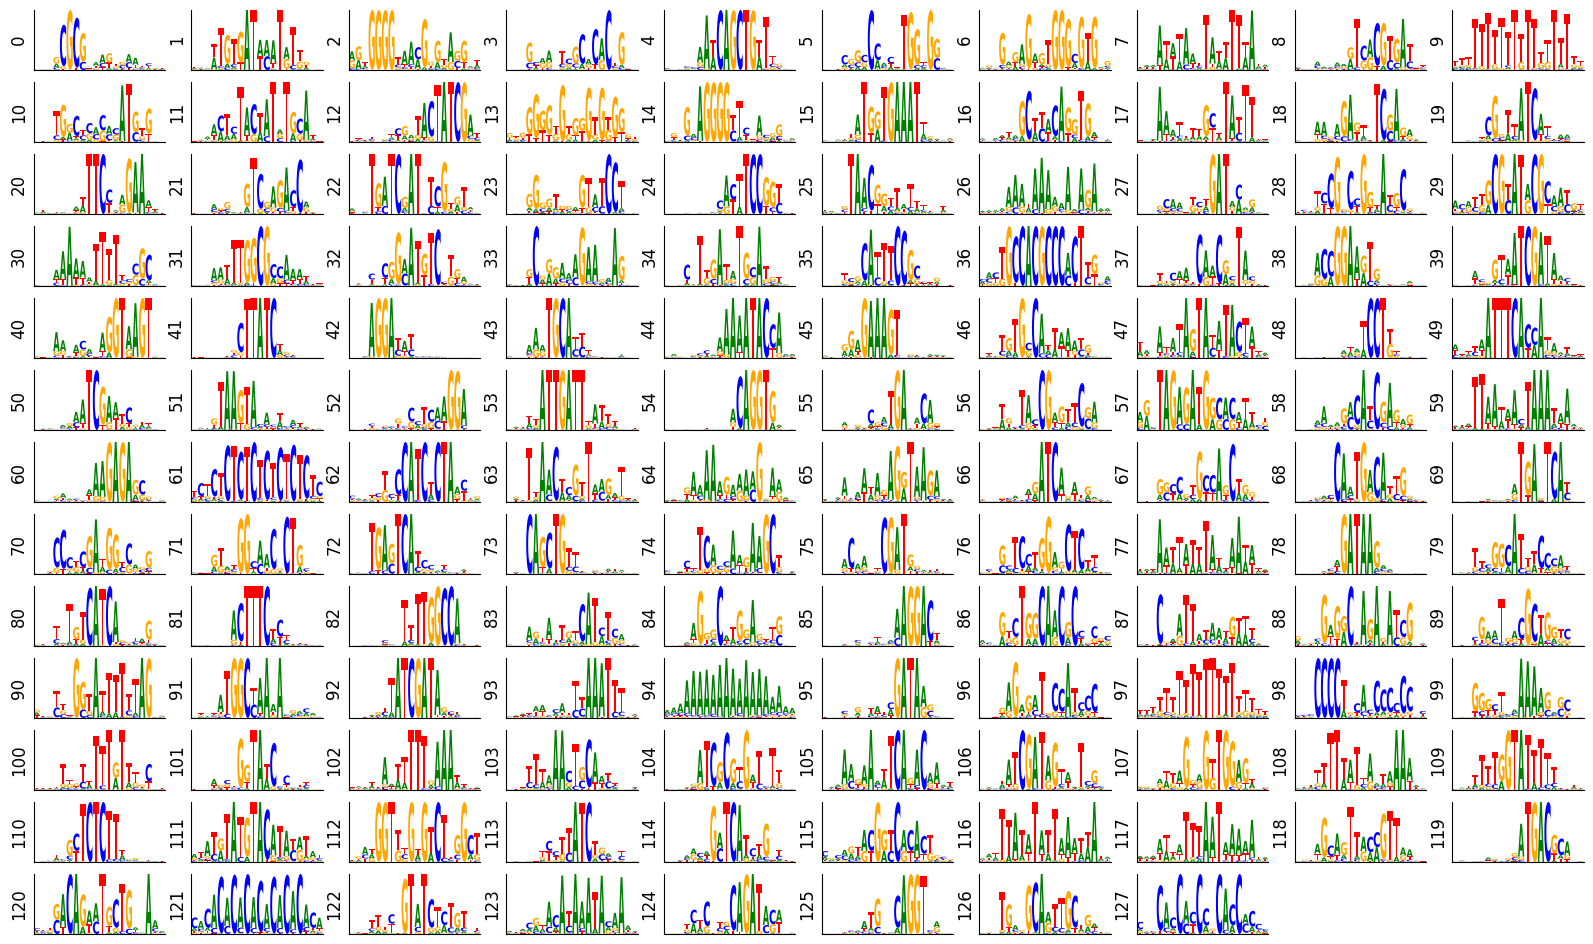

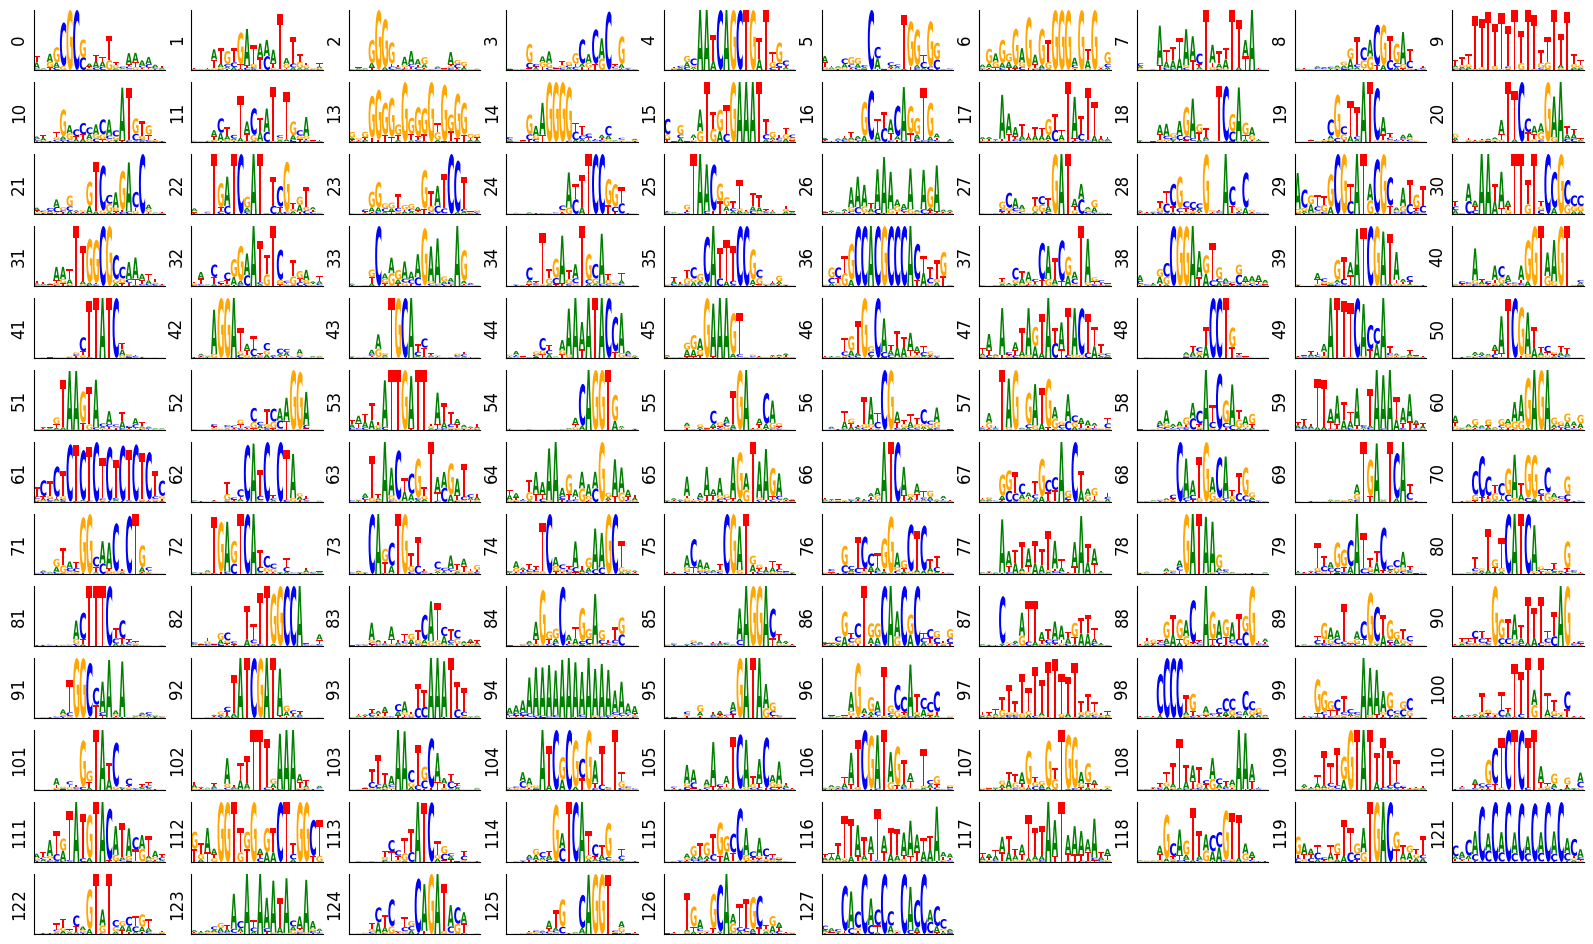

In [7]:
# interpret model
print("Evaluating first layer!")
tuner.interpret_model(layer=3)

print(f"Evaluating second layer!")
if(config['conv1_channel_weight'] == "softconv"):
    layer = 5
elif(config['conv1_channel_weight'] == "se"):
    layer = 8

tuner.interpret_model(layer=layer)

In [7]:
!echo $CUDA_VISIBLE_DEVICES

2


In [8]:
layer_index = 3
print(f"rsat matrix-clustering -matrix rsat {tuner.save_path}/filters/filters_{layer_index}_hits.jaspar jaspar -o {tuner.save_path}/filters/filter_clusters/filter_clusters_{layer_index} -v 2")

rsat matrix-clustering -matrix rsat /home/chandana/projects/hominid_pipeline/results/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/variations/128-filters//filters/filters_3_hits.jaspar jaspar -o /home/chandana/projects/hominid_pipeline/results/experiments/model_variations/tune_hominid_8f34a_00056_56_conv1_activation=relu,conv1_attention_pool_size=5,conv1_batchnorm=False,conv1_channel_weight=se,conv1__2023-05-17_22-05-53/exponential/variations/128-filters//filters/filter_clusters/filter_clusters_3 -v 2


In [7]:
# parse the table containing clustered filter indices
cluster_df = pd.read_csv(f"{tuner.save_path}/filters/filter_clusters/filter_clusters_{layer_index}_tables/clusters_motif_names.tab", sep="\t", header=None)
cluster_df.columns = ["cluster_id", "filters"]

rsat_filter_order = []

for index in range(len(cluster_df)):

    filter_list = [i.split("-")[0] for i in cluster_df.loc[index]["filters"].split(",")]
    filter_list = [int(i.split("_")[-1]) for i in filter_list]
    
    rsat_filter_order += filter_list

# store the filter indices in the rsat_filter_order variable
rsat_filter_order

[23,
 167,
 73,
 186,
 17,
 195,
 33,
 66,
 149,
 251,
 22,
 0,
 177,
 58,
 140,
 183,
 12,
 242,
 152,
 21,
 179,
 164,
 122,
 36,
 150,
 83,
 214,
 245,
 161,
 146,
 75,
 240,
 247,
 14,
 221,
 197,
 85,
 208,
 212,
 124,
 226,
 176,
 175,
 11,
 189,
 104,
 72,
 243,
 24,
 170,
 32,
 2,
 90,
 159,
 181,
 108,
 86,
 18,
 220,
 156,
 162,
 201,
 105,
 133,
 198,
 185,
 52,
 192,
 224,
 137,
 206,
 244,
 62,
 69,
 238,
 123,
 147,
 143,
 44,
 207,
 96,
 101,
 15,
 117,
 81,
 205,
 219,
 102,
 89,
 9,
 46,
 193,
 210,
 100,
 97,
 237,
 54,
 121,
 120,
 113,
 3,
 166,
 249,
 174,
 78,
 20,
 61,
 26,
 233,
 84,
 115,
 252,
 60,
 68,
 199,
 246,
 34,
 160,
 74,
 103,
 127,
 8,
 165,
 200,
 107,
 118,
 30,
 56,
 223,
 196,
 38,
 63,
 55,
 232,
 71,
 39,
 222,
 82,
 28,
 53,
 16,
 80,
 248,
 41,
 215,
 145,
 173,
 119,
 204,
 136,
 216,
 180,
 213,
 126,
 42,
 35,
 10,
 79,
 172,
 27,
 40,
 141,
 64,
 76,
 4,
 59,
 169,
 48,
 114,
 236,
 91,
 255,
 129,
 178,
 25,
 77,
 153,
 139,
 57,
 211,


Loading filters...


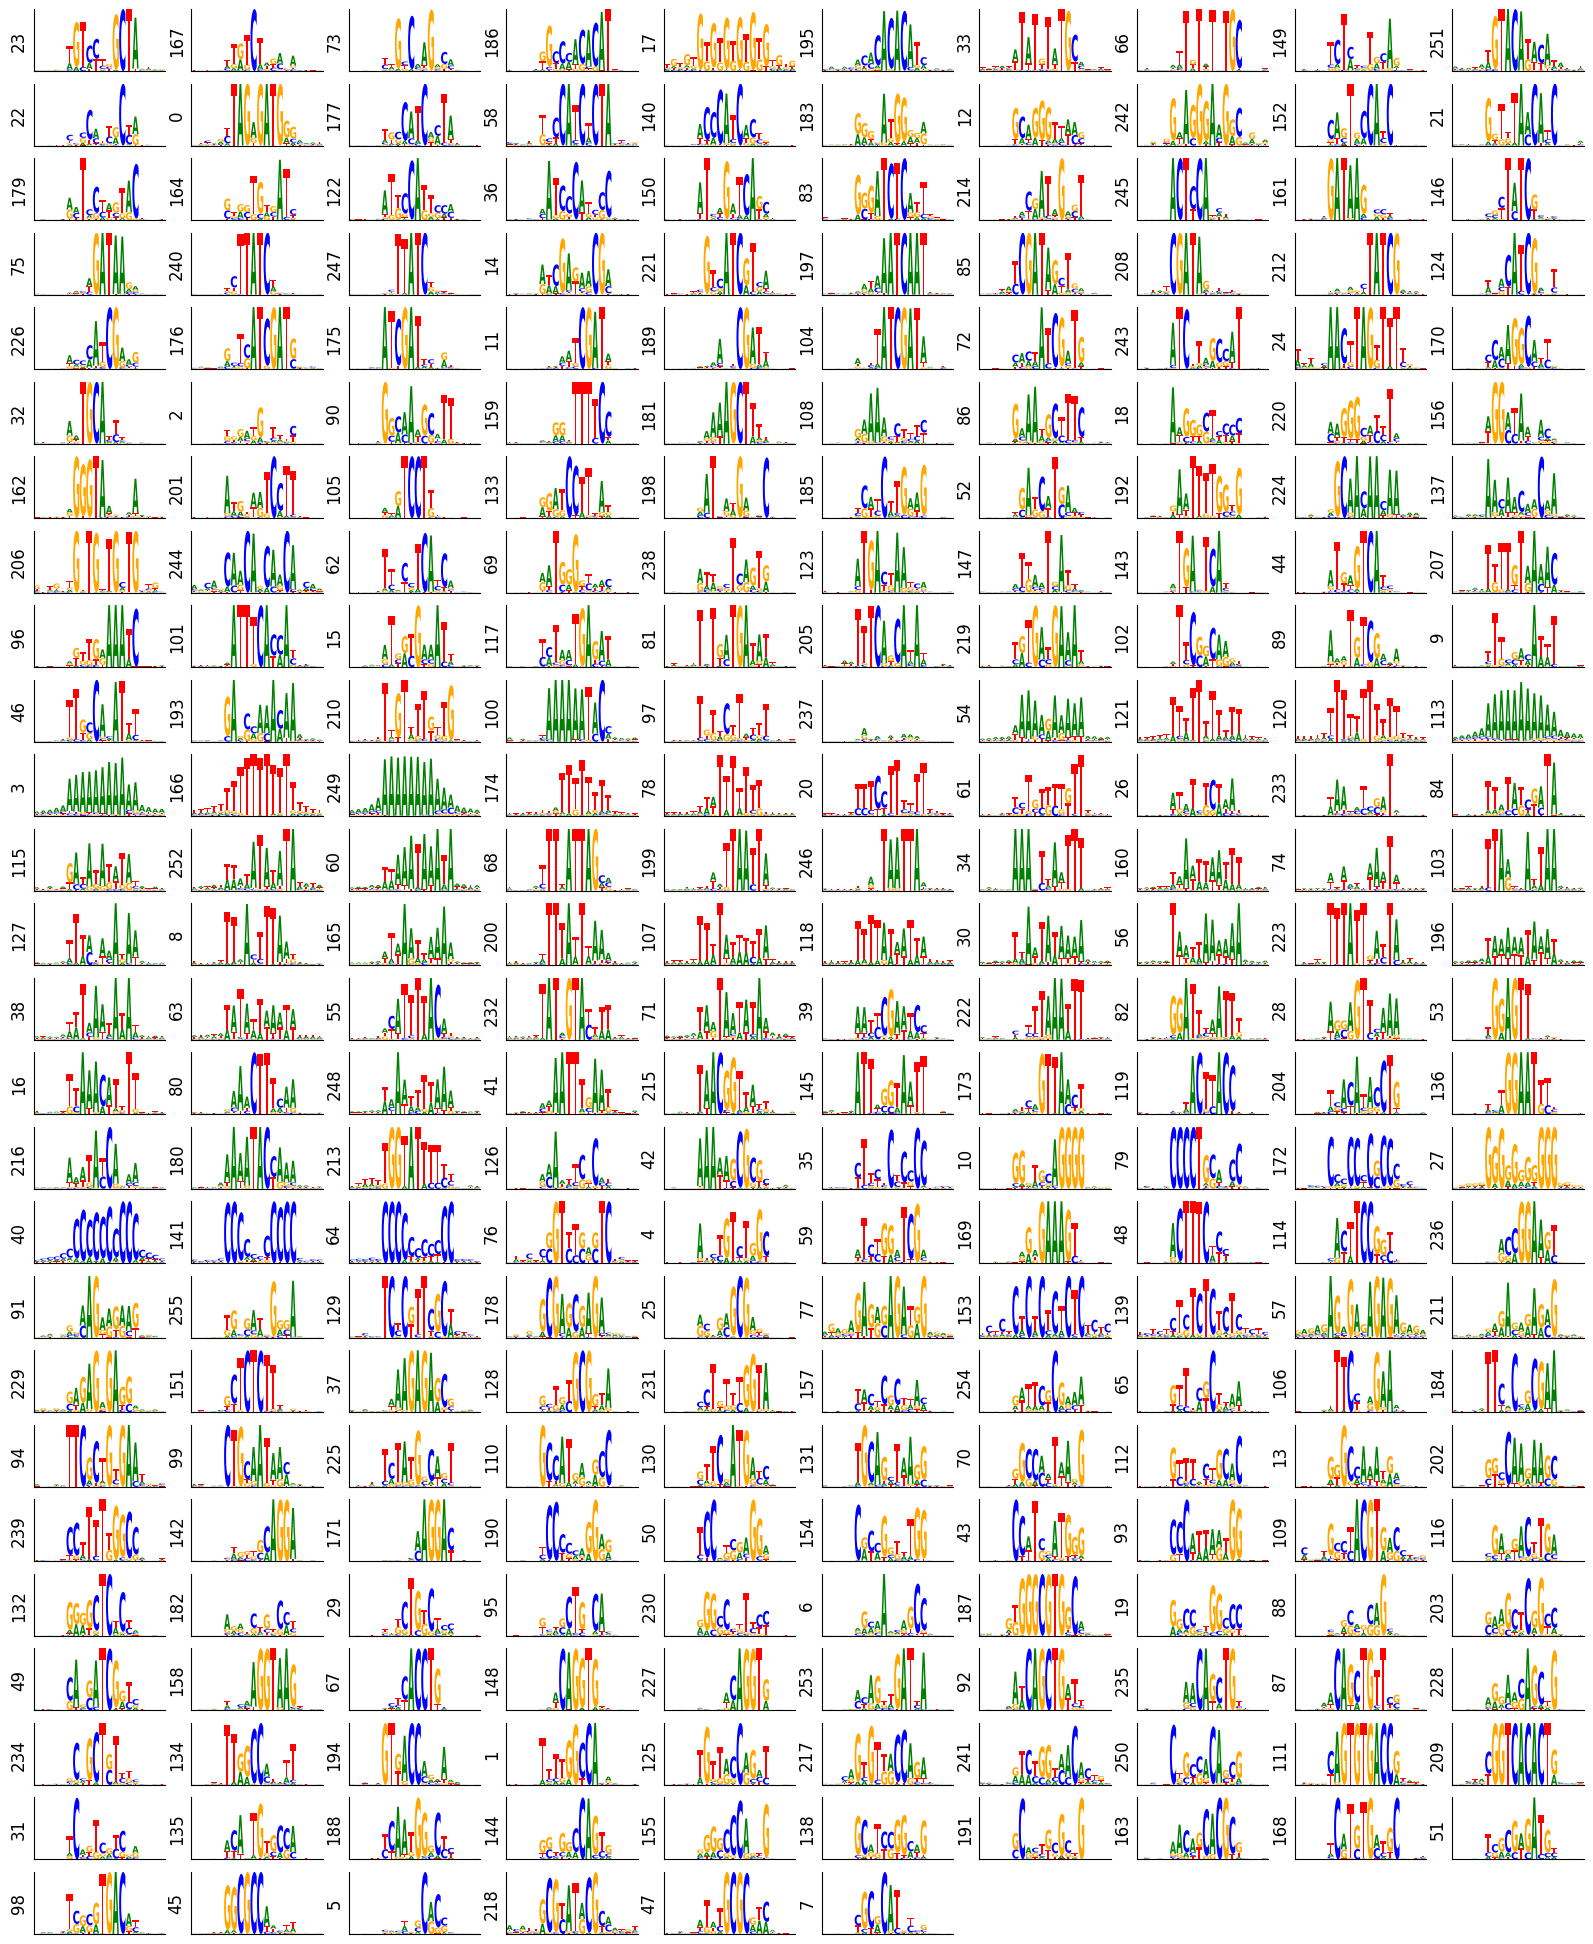

In [8]:
print("Loading filters...")
with h5py.File(f"{tuner.save_path}/filters/filters_{layer_index}.h5", "r") as f:
    W = f["filters"][:]
#     sub_W = f["filters_subset"][:]
#     counts = f["filters"][:]

# plot filters after RSAT clustering:
fig = plt.figure(figsize=(20, model.layers[1].get_weights()[0].shape[-1]//10))
W_df = impress.plot_filters(W[rsat_filter_order], fig, num_cols=10, fontsize=12, names=rsat_filter_order)
# fig.savefig(f"{filters_path}/clustered_filters.pdf", format='pdf', dpi=200, bbox_inches='tight')

Computing saliency maps...


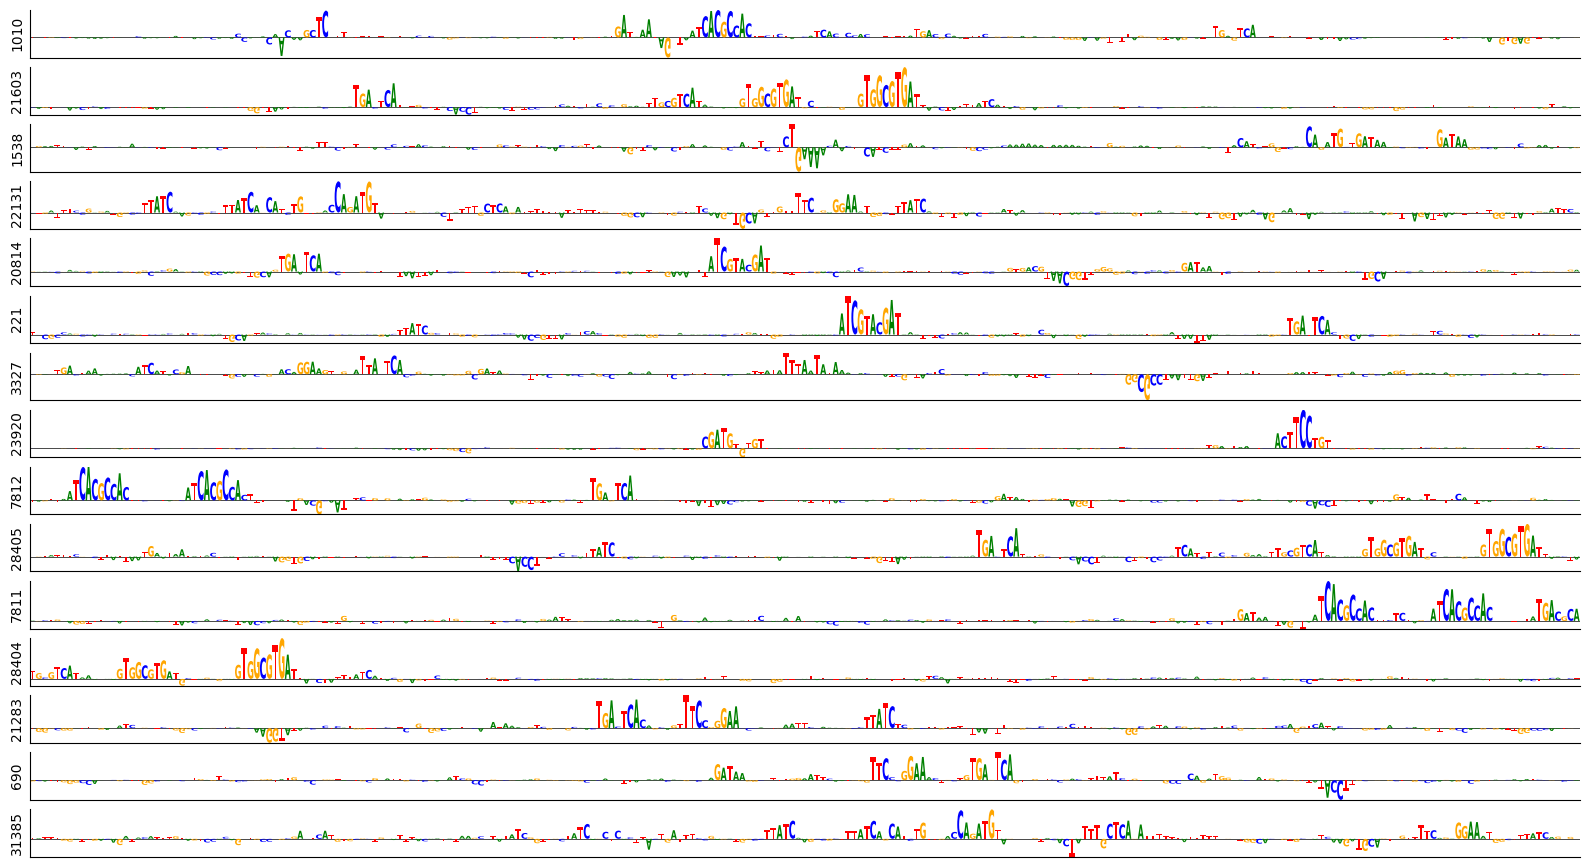

In [11]:
saliency_path = f"{tuner.save_path}/saliency"

print("Computing saliency maps...")
# plot 15 sequences with highest activity for a given class
num_plot = 15

# sort sequences by highest activity
sort = np.argsort(y_test[:,0])[::-1][:num_plot]
X = x_test[sort]

# calculate attribution maps
saliency_path = f"{tuner.save_path}/saliency/saliency_maps_0.pkl"
saliency_scores = utils.load_predictions_from_file(saliency_path)
saliency_scores = np.concatenate(saliency_scores, axis=0)[sort]

# gradient correction. (Majdandzic et al. bioRxiv, 2022)
saliency_scores -= np.mean(saliency_scores, axis=2, keepdims=True)

fig = plt.figure(figsize=(20, 11))
for i, index in enumerate(range(num_plot)):
    x = np.expand_dims(X[index], axis=0)
    scores = np.expand_dims(saliency_scores[index], axis=0)
    scores -= np.mean(scores, axis=2, keepdims=True)
    saliency_df = impress.grad_times_input_to_df(x, scores)

    ax = plt.subplot(num_plot,1,i+1)
    impress.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    plt.ylabel(sort[i])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 256)    253696      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 249, 256)     1024        ['pairwise_conv1d[0][0]']        
                                                                                                  
 conv1_activation (Activation)  (None, 249, 256)     0           ['conv1_bn[0][0]']           

                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 12,847,938
Trainable params: 12,845,378
Non-trainable params: 2,560
__________________________________________________________________________________________________


In [22]:
lays

[keras.engine.input_layer.InputLayer,
 hominid_pipeline.layers.PairwiseConv1D,
 keras.layers.normalization.batch_normalization.BatchNormalization,
 keras.layers.core.activation.Activation,
 keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D,
 keras.layers.core.dense.Dense,
 keras.layers.core.dense.Dense,
 keras.layers.reshaping.reshape.Reshape,
 keras.layers.core.tf_op_layer.TFOpLambda,
 keras.layers.regularization.dropout.Dropout,
 hominid_pipeline.layers.MultiHeadAttention,
 hominid_pipeline.layers.MultiHeadAttention,
 keras.layers.regularization.dropout.Dropout,
 keras.layers.regularization.dropout.Dropout,
 keras.layers.reshaping.flatten.Flatten,
 keras.layers.reshaping.flatten.Flatten,
 keras.layers.core.dense.Dense,
 keras.layers.core.dense.Dense,
 keras.layers.normalization.batch_normalization.BatchNormalization,
 keras.layers.normalization.batch_normalization.BatchNormalization,
 keras.layers.core.activation.Activation,
 keras.layers.core.activation.Activation

In [23]:
lays.index(layers.MultiHeadAttention)

10

In [25]:
# for this model ONLY: challenges are that there is no pooling layer
# so selected the concatenation layer for the conv_layer
import time
t1 = time.time()
sample = x_test[:5000]
lays = [type(i) for i in model.layers]
c_index = lays.index(keras.layers.core.tf_op_layer.TFOpLambda) #lays.index(tf.keras.layers.MaxPool1D)

mha_index = lays.index(layers.MultiHeadAttention)
correlation_map = utils.correlation_matrix(
                            model, 
                            c_index, 
                            mha_index, 
                            sample, 
                            thresh=0.1, 
                            random_frac=0.3, 
                            limit=150000
                        )
t2 = time.time()

print(f"Time taken: {t2-t1}")

157/157 [==============================] - 1s 1ms/step


2023-06-09 10:02:25.701055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


157/157 [==============================] - 1s 3ms/step


/home/chandana/projects/hominid_pipeline/hominid_pipeline/utils.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filter_interactions = feature_maps[position_pairs].transpose([1, 2, 0])


Time taken: 507.90930819511414


In [27]:
# save correlation map to an h5 file
glifac_path = f"{tuner.save_path}/glifac"
utils.make_directory(glifac_path)

file_path = f"{glifac_path}/correlation_map.h5"
with h5py.File(file_path, "w") as f:
    dset = f.create_dataset(name="correlation_map", data=correlation_map, dtype='float32')

In [28]:
len(rsat_filter_order)

256

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f9f4443f710>)

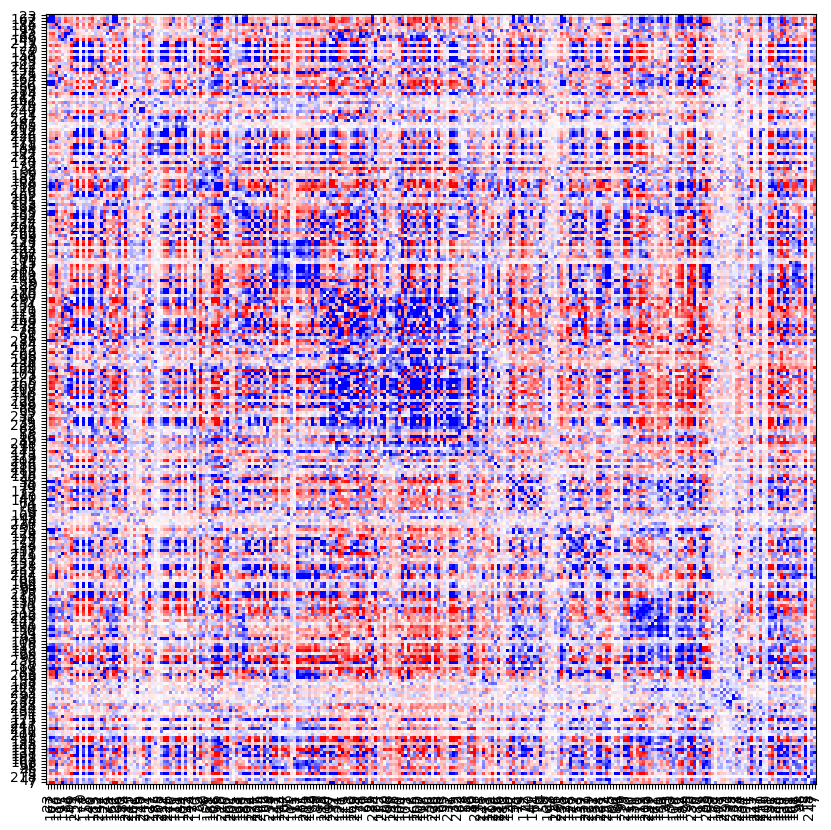

In [29]:
# create heatmap (only showing 25 filters here)
motif_order = rsat_filter_order
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
utils.plot_glifac(
                    ax,
                    np.clip(correlation_map, -1, 1)[motif_order][:,motif_order],
                    motif_order,
                    vmin=-0.15,
                    vmax=0.15
                )
# fig.savefig(f'{glifac_path}/glifac_interactions.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [ ]:
# create heatmap (only showing 25 filters here)
motif_order = rsat_filter_order
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
utils.plot_glifac(
                    ax,
                    np.clip(correlation_map, -1, 1)[motif_order][:,motif_order],
                    motif_order,
                    vmin=-0.15,
                    vmax=0.15
                )
# fig.savefig(f'{glifac_path}/glifac_interactions.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [30]:
from hominid_pipeline import gia_utils

In [31]:
alphabet = 'ACGT'
gia = gia_utils.GlobalImportance(model, alphabet)
gia.set_null_model('random', base_sequence=x_test, num_sample=2000, base_scores=y_test[:,0])  
gia.filter_null(low=10, high=90, num_sample=1000)

32/32 [==============================] - 0s 6ms/step


In [ ]:
position = 125
class_index = 0

print('ap1')
ap1 = 'NNTCACGCANN'
ap1_flank_scores, ap1_flanks = gia.optimal_flanks(ap1, position, class_index)
ap1 = ap1_flanks[0]

print('dre')
dre = 'NNTATCGATATANN'
dre_flank_scores, dre_flanks = gia.optimal_flanks(dre, position, class_index)
dre = dre_flanks[0]

print('dref')
dref = 'NNCGATGGNN'
dref_flank_scores, dref_flanks = gia.optimal_flanks(dref, position, class_index)
dref = dref_flanks[0]

print('gata')
gata = 'NNGATAANN'
gata_flank_scores, gata_flanks = gia.optimal_flanks(gata, position, class_index)
gata = gata_flanks[0]

print('gata_rc')
gata_rc = 'NNTTATCNN'
gata_rc_flank_scores, gata_rc_flanks = gia.optimal_flanks(gata_rc, position, class_index)
gata_rc = gata_rc_flanks[0]

print('ohler5')
ohler5 = 'NNCAGCTGNN'
ohler5_flank_scores, ohler5_flanks = gia.optimal_flanks(ohler5, position, class_index)
ohler5 = ohler5_flanks[0]

print('ohler7')
ohler7 = 'NNCATCGCTGNN'
ohler7_flank_scores, ohler7_flanks = gia.optimal_flanks(ohler7, position, class_index)
ohler7 = ohler7_flanks[0]

print('mitf')
mitf = 'NNTCACGTGANN'
mitf_flank_scores, mitf_flanks = gia.optimal_flanks(mitf, position, class_index)
mitf = mitf_flanks[0]

print('ohler1')
ohler1 = 'NCAGTGTGACCGN'
ohler1_flank_scores, ohler1_flanks = gia.optimal_flanks(ohler1, position, class_index)
ohler1 = ohler1_flanks[0]

print('ohler1_rc')
ohler1_rc = 'NCGGTCACACTGN'
ohler1_rc_flank_scores, ohler1_rc_flanks = gia.optimal_flanks(ohler1_rc, position, class_index)
ohler1_rc = ohler1_rc_flanks[0]


flank_scores0 = {
    'ap1': ap1_flank_scores,
    'dre': dre_flank_scores,
    'dref': dref_flank_scores,
    'gata': gata_flank_scores,
    'gata_rc': gata_rc_flank_scores,
    'ohler5': ohler5_flank_scores,
    'ohler7': ohler7_flank_scores,
    'mitf': mitf_flank_scores,
    'ohler1': ohler1_flank_scores,
    'ohler1_rc': ohler1_rc_flank_scores,
}

flanks0 = {
    'ap1': ap1_flanks,
    'dre': dre_flanks,
    'dref': dref_flanks,
    'gata': gata_flanks,
    'gata_rc': gata_rc_flanks,
    'ohler5': ohler5_flanks,
    'ohler7': ohler7_flanks,
    'mitf': mitf_flanks,
    'ohler1': ohler1_flanks,
    'ohler1_rc': ohler1_rc_flanks,
}

motifs0 = {
    'ap1': ap1,
    'dre': dre,
    'dref': dref,
    'gata': gata,
    'gata_rc': gata_rc,
    'ohler5': ohler5,
    'ohler7': ohler7,
    'mitf': mitf,
    'ohler1': ohler1,
    'ohler1_rc': ohler1_rc,
    'ohler6': 'AAAATACCAAA',
    'ohler6_rc': 'TTTGGTATTTTT',
    'stat': 'TTCCCGGAA',
    'ts01': 'AAATTTAAAA',
    'cebp': 'TGGTGAAAT',
    'at': 'AATAAA',
    'ga': 'GAGAGAGAGAGA',
    'ct': 'CTCTCTCTCTCT',
    'myb': 'CGCG',
    'context': 'GGGCT',
}


In [ ]:
position = 125
class_index = 1

print('ap1')
ap1 = 'NNTCACGCANN'
ap1_flank_scores, ap1_flanks = gia.optimal_flanks(ap1, position, class_index)
ap1 = ap1_flanks[0]

print('dre')
dre = 'NNTATCGATATANN'
dre_flank_scores, dre_flanks = gia.optimal_flanks(dre, position, class_index)
dre = dre_flanks[0]

print('dref')
dref = 'NNCGATGGNN'
dref_flank_scores, dref_flanks = gia.optimal_flanks(dref, position, class_index)
dref = dref_flanks[0]

print('gata')
gata = 'NNGATAANN'
gata_flank_scores, gata_flanks = gia.optimal_flanks(gata, position, class_index)
gata = gata_flanks[0]

print('gata_rc')
gata_rc = 'NNTTATCNN'
gata_rc_flank_scores, gata_rc_flanks = gia.optimal_flanks(gata_rc, position, class_index)
gata_rc = gata_rc_flanks[0]

print('ohler5')
ohler5 = 'NNCAGCTGNN'
ohler5_flank_scores, ohler5_flanks = gia.optimal_flanks(ohler5, position, class_index)
ohler5 = ohler5_flanks[0]

print('ohler7')
ohler7 = 'NNCATCGCTGNN'
ohler7_flank_scores, ohler7_flanks = gia.optimal_flanks(ohler7, position, class_index)
ohler7 = ohler7_flanks[0]

print('mitf')
mitf = 'NNTCACGTGANN'
mitf_flank_scores, mitf_flanks = gia.optimal_flanks(mitf, position, class_index)
mitf = mitf_flanks[0]

print('ohler1')
ohler1 = 'NCAGTGTGACCGN'
ohler1_flank_scores, ohler1_flanks = gia.optimal_flanks(ohler1, position, class_index)
ohler1 = ohler1_flanks[0]

print('ohler1_rc')
ohler1_rc = 'NCGGTCACACTGN'
ohler1_rc_flank_scores, ohler1_rc_flanks = gia.optimal_flanks(ohler1_rc, position, class_index)
ohler1_rc = ohler1_rc_flanks[0]


flank_scores1 = {
    'ap1': ap1_flank_scores,
    'dre': dre_flank_scores,
    'dref': dref_flank_scores,
    'gata': gata_flank_scores,
    'gata_rc': gata_rc_flank_scores,
    'ohler5': ohler5_flank_scores,
    'ohler7': ohler7_flank_scores,
    'mitf': mitf_flank_scores,
    'ohler1': ohler1_flank_scores,
    'ohler1_rc': ohler1_rc_flank_scores,
}

flanks1 = {
    'ap1': ap1_flanks,
    'dre': dre_flanks,
    'dref': dref_flanks,
    'gata': gata_flanks,
    'gata_rc': gata_rc_flanks,
    'ohler5': ohler5_flanks,
    'ohler7': ohler7_flanks,
    'mitf': mitf_flanks,
    'ohler1': ohler1_flanks,
    'ohler1_rc': ohler1_rc_flanks,
}

motifs1 = {
    'ap1': ap1,
    'dre': dre,
    'dref': dref,
    'gata': gata,
    'gata_rc': gata_rc,
    'ohler5': ohler5,
    'ohler7': ohler7,
    'mitf': mitf,
    'ohler1': ohler1,
    'ohler1_rc': ohler1_rc,
    'ohler6': 'AAAATACCAAA',
    'ohler6_rc': 'TTTGGTATTTTT',
    'stat': 'TTCCCGGAA',
    'ts01': 'AAATTTAAAA',
    'cebp': 'TGGTGAAAT',
    'at': 'AATAAA',
    'ga': 'GAGAGAGAGAGA',
    'ct': 'CTCTCTCTCTCT',
    'myb': 'CGCG',
    'context': 'GGGCT',
}


In [ ]:
start = 50
end = 200
class_index = 0

print('ap1')
ap1_pos_scores, ap1_pos = gia.optimal_position(motifs0['ap1'], start, end, class_index)
ap1_index = ap1_pos[np.argmax(np.mean(ap1_pos_scores, axis=1))]

print('dre')
dre_pos_scores, dre_pos = gia.optimal_position(motifs0['dre'], start, end, class_index)
dre_index = dre_pos[np.argmax(np.mean(dre_pos_scores, axis=1))]

print('dref')
dref_pos_scores, dref_pos = gia.optimal_position(motifs0['dref'], start, end, class_index)
dref_index = dref_pos[np.argmax(np.mean(dref_pos_scores, axis=1))]

print('gata')
gata_pos_scores, gata_pos = gia.optimal_position(motifs0['gata'], start, end, class_index)
gata_index = gata_pos[np.argmax(np.mean(gata_pos_scores, axis=1))]

print('gata_rc')
gata_rc_pos_scores, gata_rc_pos = gia.optimal_position(motifs0['gata_rc'], start, end, class_index)
gata_rc_index = gata_rc_pos[np.argmax(np.mean(gata_rc_pos_scores, axis=1))]

print('ohler5')
ohler5_pos_scores, ohler5_pos = gia.optimal_position(motifs0['ohler5'], start, end, class_index)
ohler5_index = ohler5_pos[np.argmax(np.mean(ohler5_pos_scores, axis=1))]

print('ohler7')
ohler7_pos_scores, ohler7_pos = gia.optimal_position(motifs0['ohler7'], start, end, class_index)
ohler7_index = ohler7_pos[np.argmax(np.mean(ohler7_pos_scores, axis=1))]

print('mitf')
mitf_pos_scores, mitf_pos = gia.optimal_position(motifs0['mitf'], start, end, class_index)
mitf_index = mitf_pos[np.argmax(np.mean(mitf_pos_scores, axis=1))]

print('ohler1')
ohler1_pos_scores, ohler1_pos = gia.optimal_position(motifs0['ohler1'], start, end, class_index)
ohler1_index = ohler1_pos[np.argmax(np.mean(ohler1_pos_scores, axis=1))]

print('ohler1_rc')
ohler1_rc_pos_scores, ohler1_rc_pos = gia.optimal_position(motifs0['ohler1_rc'], start, end, class_index)
ohler1_rc_index = ohler1_rc_pos[np.argmax(np.mean(ohler1_rc_pos_scores, axis=1))]

print('ohler6')
ohler6_pos_scores, ohler6_pos = gia.optimal_position(motifs0['ohler6'], start, end, class_index)
ohler6_index = ohler6_pos[np.argmax(np.mean(ohler6_pos_scores, axis=1))]

print('ohler6_rc')
ohler6_rc_pos_scores, ohler6_rc_pos = gia.optimal_position(motifs0['ohler6_rc'], start, end, class_index)
ohler6_rc_index = ohler6_rc_pos[np.argmax(np.mean(ohler6_rc_pos_scores, axis=1))]

print('stat')
stat_pos_scores, stat_pos = gia.optimal_position(motifs0['stat'], start, end, class_index)
stat_index = stat_pos[np.argmax(np.mean(stat_pos_scores, axis=1))]

print('ts01')
ts01_pos_scores, ts01_pos = gia.optimal_position(motifs0['ts01'], start, end, class_index)
ts01_index = ts01_pos[np.argmax(np.mean(ts01_pos_scores, axis=1))]

print('cebp')
cebp_pos_scores, cebp_pos = gia.optimal_position(motifs0['cebp'], start, end, class_index)
cebp_index = cebp_pos[np.argmax(np.mean(cebp_pos_scores, axis=1))]

pos_scores0 = {
    'ap1': ap1_pos_scores,
    'dre': dre_pos_scores,
    'dref': dref_pos_scores,
    'gata': gata_pos_scores,
    'gata_rc': gata_rc_pos_scores,
    'ohler5': ohler5_pos_scores,
    'ohler7': ohler7_pos_scores,
    'mitf': mitf_pos_scores,
    'ohler1': ohler1_pos_scores,
    'ohler1_rc': ohler1_rc_pos_scores,
    'ohler6': ohler6_pos_scores,
    'ohler6_rc': ohler6_rc_pos_scores,
    'stat': stat_pos_scores,
    'ts01': ts01_pos_scores,
    'cebp': cebp_pos_scores,
}

pos_index0 = {
    'ap1': ap1_index,
    'dre': dre_index,
    'dref': dref_index,
    'gata': gata_index,
    'gata_rc': gata_rc_index,
    'ohler5': ohler5_index,
    'ohler7': ohler7_index,
    'mitf': mitf_index,
    'ohler1': ohler1_index,
    'ohler1_rc': ohler1_rc_index,
    'ohler6': ohler6_index,
    'ohler6_rc': ohler6_rc_index,
    'stat': stat_index,
    'ts01': ts01_index,
    'cebp': cebp_index,
}

In [ ]:
start = 50
end = 200
class_index = 1

print('ap1')
ap1_pos_scores, ap1_pos = gia.optimal_position(motifs1['ap1'], start, end, class_index)
ap1_index = ap1_pos[np.argmax(np.mean(ap1_pos_scores, axis=1))]

print('dre')
dre_pos_scores, dre_pos = gia.optimal_position(motifs1['dre'], start, end, class_index)
dre_index = dre_pos[np.argmax(np.mean(dre_pos_scores, axis=1))]

print('dref')
dref_pos_scores, dref_pos = gia.optimal_position(motifs1['dref'], start, end, class_index)
dref_index = dref_pos[np.argmax(np.mean(dref_pos_scores, axis=1))]

print('gata')
gata_pos_scores, gata_pos = gia.optimal_position(motifs1['gata'], start, end, class_index)
gata_index = gata_pos[np.argmax(np.mean(gata_pos_scores, axis=1))]

print('gata_rc')
gata_rc_pos_scores, gata_rc_pos = gia.optimal_position(motifs1['gata_rc'], start, end, class_index)
gata_rc_index = gata_rc_pos[np.argmax(np.mean(gata_rc_pos_scores, axis=1))]

print('ohler5')
ohler5_pos_scores, ohler5_pos = gia.optimal_position(motifs1['ohler5'], start, end, class_index)
ohler5_index = ohler5_pos[np.argmax(np.mean(ohler5_pos_scores, axis=1))]

print('ohler7')
ohler7_pos_scores, ohler7_pos = gia.optimal_position(motifs1['ohler7'], start, end, class_index)
ohler7_index = ohler7_pos[np.argmax(np.mean(ohler7_pos_scores, axis=1))]

print('mitf')
mitf_pos_scores, mitf_pos = gia.optimal_position(motifs1['mitf'], start, end, class_index)
mitf_index = mitf_pos[np.argmax(np.mean(mitf_pos_scores, axis=1))]

print('ohler1')
ohler1_pos_scores, ohler1_pos = gia.optimal_position(motifs1['ohler1'], start, end, class_index)
ohler1_index = ohler1_pos[np.argmax(np.mean(ohler1_pos_scores, axis=1))]

print('ohler1_rc')
ohler1_rc_pos_scores, ohler1_rc_pos = gia.optimal_position(motifs1['ohler1_rc'], start, end, class_index)
ohler1_rc_index = ohler1_rc_pos[np.argmax(np.mean(ohler1_rc_pos_scores, axis=1))]

print('ohler6')
ohler6_pos_scores, ohler6_pos = gia.optimal_position(motifs1['ohler6'], start, end, class_index)
ohler6_index = ohler6_pos[np.argmax(np.mean(ohler6_pos_scores, axis=1))]

print('ohler6_rc')
ohler6_rc_pos_scores, ohler6_rc_pos = gia.optimal_position(motifs1['ohler6_rc'], start, end, class_index)
ohler6_rc_index = ohler6_rc_pos[np.argmax(np.mean(ohler6_rc_pos_scores, axis=1))]

print('stat')
stat_pos_scores, stat_pos = gia.optimal_position(motifs1['stat'], start, end, class_index)
stat_index = stat_pos[np.argmax(np.mean(stat_pos_scores, axis=1))]

print('ts01')
ts01_pos_scores, ts01_pos = gia.optimal_position(motifs1['ts01'], start, end, class_index)
ts01_index = ts01_pos[np.argmax(np.mean(ts01_pos_scores, axis=1))]

print('cebp')
cebp_pos_scores, cebp_pos = gia.optimal_position(motifs1['cebp'], start, end, class_index)
cebp_index = cebp_pos[np.argmax(np.mean(cebp_pos_scores, axis=1))]

pos_scores1 = {
    'ap1': ap1_pos_scores,
    'dre': dre_pos_scores,
    'dref': dref_pos_scores,
    'gata': gata_pos_scores,
    'gata_rc': gata_rc_pos_scores,
    'ohler5': ohler5_pos_scores,
    'ohler7': ohler7_pos_scores,
    'mitf': mitf_pos_scores,
    'ohler1': ohler1_pos_scores,
    'ohler1_rc': ohler1_rc_pos_scores,
    'ohler6': ohler6_pos_scores,
    'ohler6_rc': ohler6_rc_pos_scores,
    'stat': stat_pos_scores,
    'ts01': ts01_pos_scores,
    'cebp': cebp_pos_scores,
}

pos_index1 = {
    'ap1': ap1_index,
    'dre': dre_index,
    'dref': dref_index,
    'gata': gata_index,
    'gata_rc': gata_rc_index,
    'ohler5': ohler5_index,
    'ohler7': ohler7_index,
    'mitf': mitf_index,
    'ohler1': ohler1_index,
    'ohler1_rc': ohler1_rc_index,
    'ohler6': ohler6_index,
    'ohler6_rc': ohler6_rc_index,
    'stat': stat_index,
    'ts01': ts01_index,
    'cebp': cebp_index,
}

In [ ]:
pairs = [
    #'ohler1_rc-dre',
    #'dre-ohler1_rc',
    'dre-ohler1',
    'ohler1_rc-ohler6_rc',
    'ohler7-dre',
    'dre-ohler7', 
    'ohler7-dref',
    'dref-ohler7',
    'gata-ap1',
    'gata_rc-ap1',
    'ap1-gata',
    'ap1-gata_rc',
    #'gata-ct',
    #'gata_rc-ct',
    #'gata-ga',
    #'gata_rc-ga',
    'ohler1-dre',
    
    'ohler1-ohler6',
    'ohler1-ohler6_rc',
    'ohler1_rc-ohler6',
    'ohler6-ohler1',
    'ohler6-ohler1_rc',
    'ohler6_rc-ohler1',
    'ohler6_rc-ohler1_rc',
    'ohler6-dre',
    'ohler6_rc-dre',
    'stat-ts01',
    'ts01-stat',
    'cebp-ohler1',
    'ohler1-cebp',
    'ohler5-mitf',
    'mitf-ohler5',
    'mitf-ohler1',
    'mitf-ohler6',
    'mitf-ohler7',
    'mitf-gata',
    'mitf-stat',
    'mitf-cebp',
    'gata-context',
    'ohler1-context',
    'ohler6-context',
    'ohler7-context',
    'dre-context',
    'ts01-myb',
    'mitf-myb',
    'ohler7-myb',
    'dre-ap1',
    'ap1-dre',
    'ohler1-ap1',
    'ohler1_rc-ap1',
    'ap1-ohler1',
    'ap1-ohler1_rc',
    'dre-gata',
    'dre-gata_rc',
    'gata-dre',
    'gata_rc-dre',
    'ohler6-at',
    'ohler6_rc-at',
]


interact_scores0 = {}
interact_pos_scores0 = {}
for pair in pairs:
    print(pair)
    motif1, motif2 = pair.split('-')
    scores, pos_scores = optimal_interactions(gia, motifs0[motif1], pos_index0[motif1], motifs0[motif2], window_scan=50, class_index=0)
    interact_scores0[pair] = scores
    interact_pos_scores0[pair] = pos_scores
    

interact_scores1 = {}
interact_pos_scores1 = {}
for pair in pairs:
    print(pair)
    motif1, motif2 = pair.split('-')
    scores, pos_scores = optimal_interactions(gia, motifs1[motif1], pos_index1[motif1], motifs0[motif2], window_scan=50, class_index=1)
    interact_scores1[pair] = scores
    interact_pos_scores1[pair] = pos_scores

In [ ]:
from six.moves import cPickle

with open('glifac_deepstarr_gia_results.pickle', 'wb') as fout:
    cPickle.dump(motifs0, fout)
    cPickle.dump(flanks0, fout)
    cPickle.dump(flank_scores0, fout)
    cPickle.dump(pos_scores0, fout)
    cPickle.dump(pos_index0, fout)
    cPickle.dump(interact_scores0, fout)
    cPickle.dump(interact_pos_scores0, fout)
    cPickle.dump(motifs1, fout)
    cPickle.dump(flanks1, fout)
    cPickle.dump(flank_scores1, fout)
    cPickle.dump(pos_scores1, fout)
    cPickle.dump(pos_index1, fout)
    cPickle.dump(interact_scores1, fout)
    cPickle.dump(interact_pos_scores1, fout)
    

In [33]:
pos_scores, pos = gia.optimal_position('GATAA', start=50, end=200, class_index=0)
gata_index0 = pos[np.argmax(np.mean(pos_scores, axis=1))]

pos_scores, pos = gia.optimal_position('TTATC', start=50, end=200, class_index=0)
gata_rc_index0 = pos[np.argmax(np.mean(pos_scores, axis=1))]


motif1 = 'TTATC'
motif2 = 'AGAGAGAG'
scores, pos_scores = gia_utils.optimal_interactions(gia, motif1, gata_rc_index0, motif2, window_scan=50, class_index=0)

motif1 = 'TTATC'
motif2 = 'CTCTCTCT'
scores2, pos_scores = gia_utils.optimal_interactions(gia, motif1, gata_rc_index0, motif2, window_scan=50, class_index=0)

motif1 = 'GATAA'
motif2 = 'AGAGAGAG'
scores3, pos_scores = gia_utils.optimal_interactions(gia, motif1, gata_index0, motif2, window_scan=50, class_index=0)

motif1 = 'GATAA'
motif2 = 'CTCTCTCT'
scores4, pos_scores = gia_utils.optimal_interactions(gia, motif1, gata_index0, motif2, window_scan=50, class_index=0)


32/32 [==============================] - 0s 6ms/step


32/32 [==============================] - 0s 6ms/step


In [ ]:

motif1 = 'GATAA'
motif2 = 'AGAGAGAG'
scores3, pos_scores = optimal_interactions(gia, motif1, gata_index0, motif2, window_scan=50, class_index=0)


motif1 = 'TTATC'
motif2 = 'AGAGAGAG'
scores, pos_scores = optimal_interactions(gia, motif1, gata_rc_index0, motif2, window_scan=50, class_index=0)


In [ ]:
from six.moves import cPickle

with open('glifac_gata_results.pickle', 'wb') as fout:
    cPickle.dump(scores, fout)
    cPickle.dump(scores2, fout)
    cPickle.dump(scores3, fout)
    cPickle.dump(scores4, fout)

In [ ]:

results = [
    scores3[0] - np.mean(scores3[1]) - np.mean(scores3[2]),
    scores4[0] - np.mean(scores4[1]) - np.mean(scores4[2]),
    scores[0] - np.mean(scores[1]) - np.mean(scores[2]), 
    scores2[0] - np.mean(scores2[1]) - np.mean(scores2[2]),
]

fontsize = 12
fig = plt.figure(figsize=(4,3))
box_violin_plot(results, cmap='tab10', ylabel='Importance', xlabel=None, title=None, fontsize=fontsize)
plt.axhline(0, 0, 3, linestyle='--', color='black')
#plt.ylim([-.5, 1.5])

ax = plt.gca();
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.yticks([-1, 0.0, 1, 2], fontsize=fontsize)
#plt.xticks([50, 100, 150, 200], fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(1,5), ['GATA::AG', 'GATA::CT', 'GATA_rc::AG', 'GATA_rc::CT'], fontsize=fontsize, rotation=45, ha='right', rotation_mode='anchor')
plt.ylim([-1,2])

fig.savefig('gata_context_comparison.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [ ]:

results = [
    scores3[0] - np.mean(scores3[1]) - np.mean(scores3[2]),
    scores4[0] - np.mean(scores4[1]) - np.mean(scores4[2]),
    scores[0] - np.mean(scores[1]) - np.mean(scores[2]), 
    scores2[0] - np.mean(scores2[1]) - np.mean(scores2[2]),
]

fontsize = 12
fig = plt.figure(figsize=(4,3))
box_violin_plot(results, cmap='tab10', ylabel='Importance', xlabel=None, title=None, fontsize=fontsize)
plt.axhline(0, 0, 3, linestyle='--', color='black')
#plt.ylim([-.5, 1.5])

ax = plt.gca();
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.yticks([-1, 0.0, 1, 2], fontsize=fontsize)
#plt.xticks([50, 100, 150, 200], fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(1,5), ['GATA::AG', 'GATA::CT', 'GATA_rc::AG', 'GATA_rc::CT'], fontsize=fontsize, rotation=45, ha='right', rotation_mode='anchor')
plt.ylim([-1,2])

fig.savefig('gata_context_comparison_deepstarr.pdf', format='pdf', dpi=200, bbox_inches='tight')